In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy.interpolate import griddata
from scipy.stats import pearsonr
import geopandas as gpd
from scipy.interpolate import griddata
from matplotlib import colors
from shapely.geometry import Point
import pandas as pd
import numpy as np
from scipy.stats import linregress
import xarray as xr
import math

### just for the variables

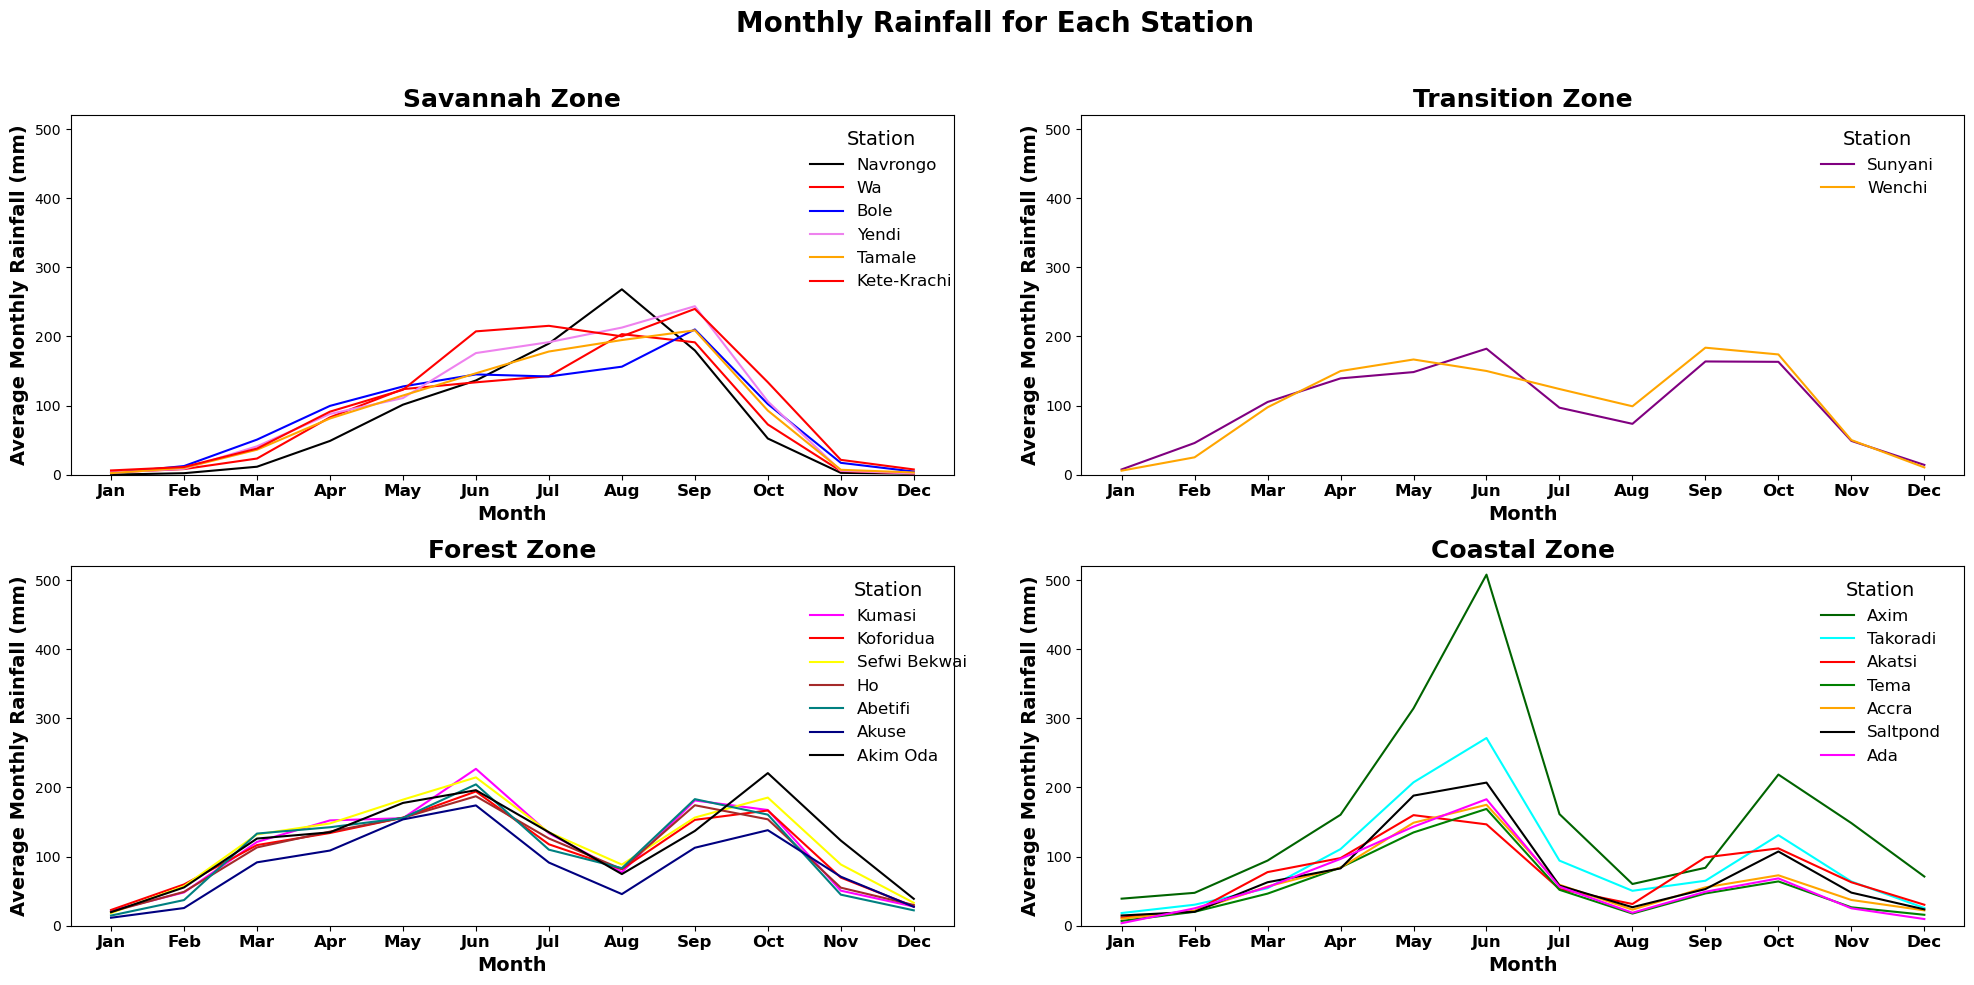

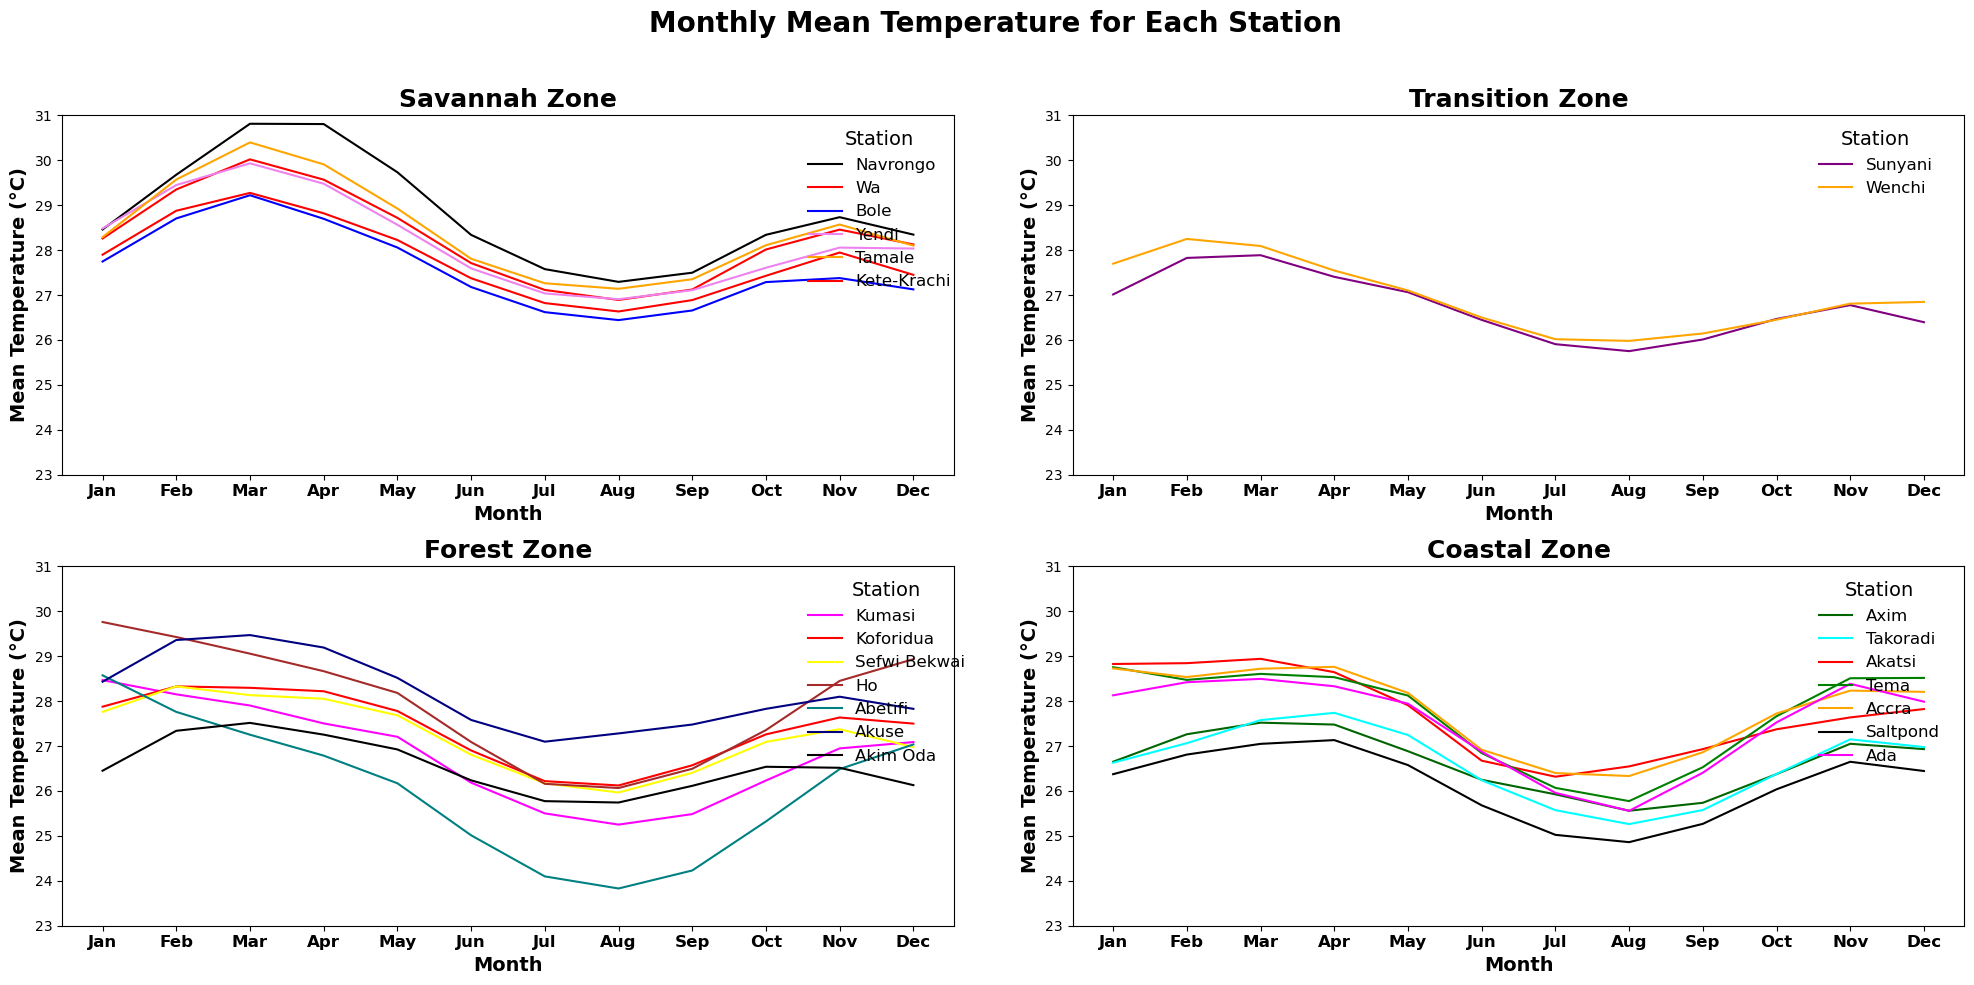

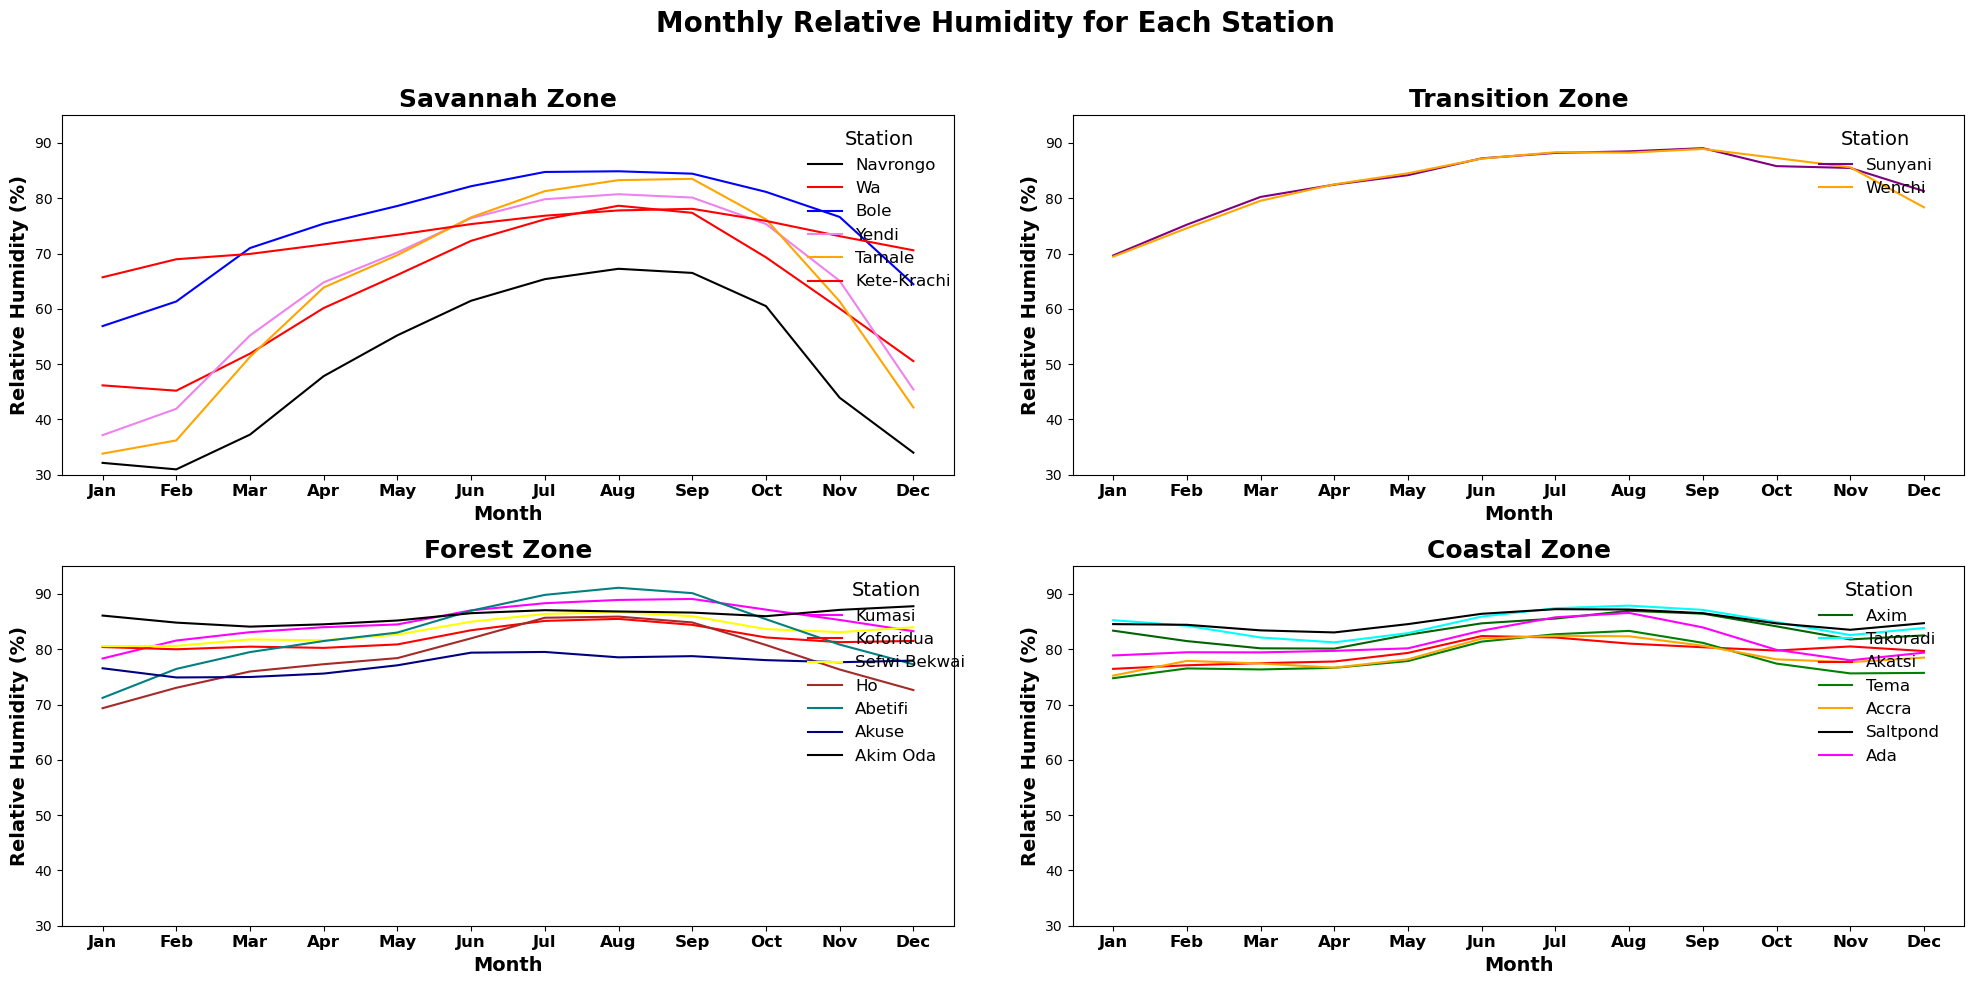

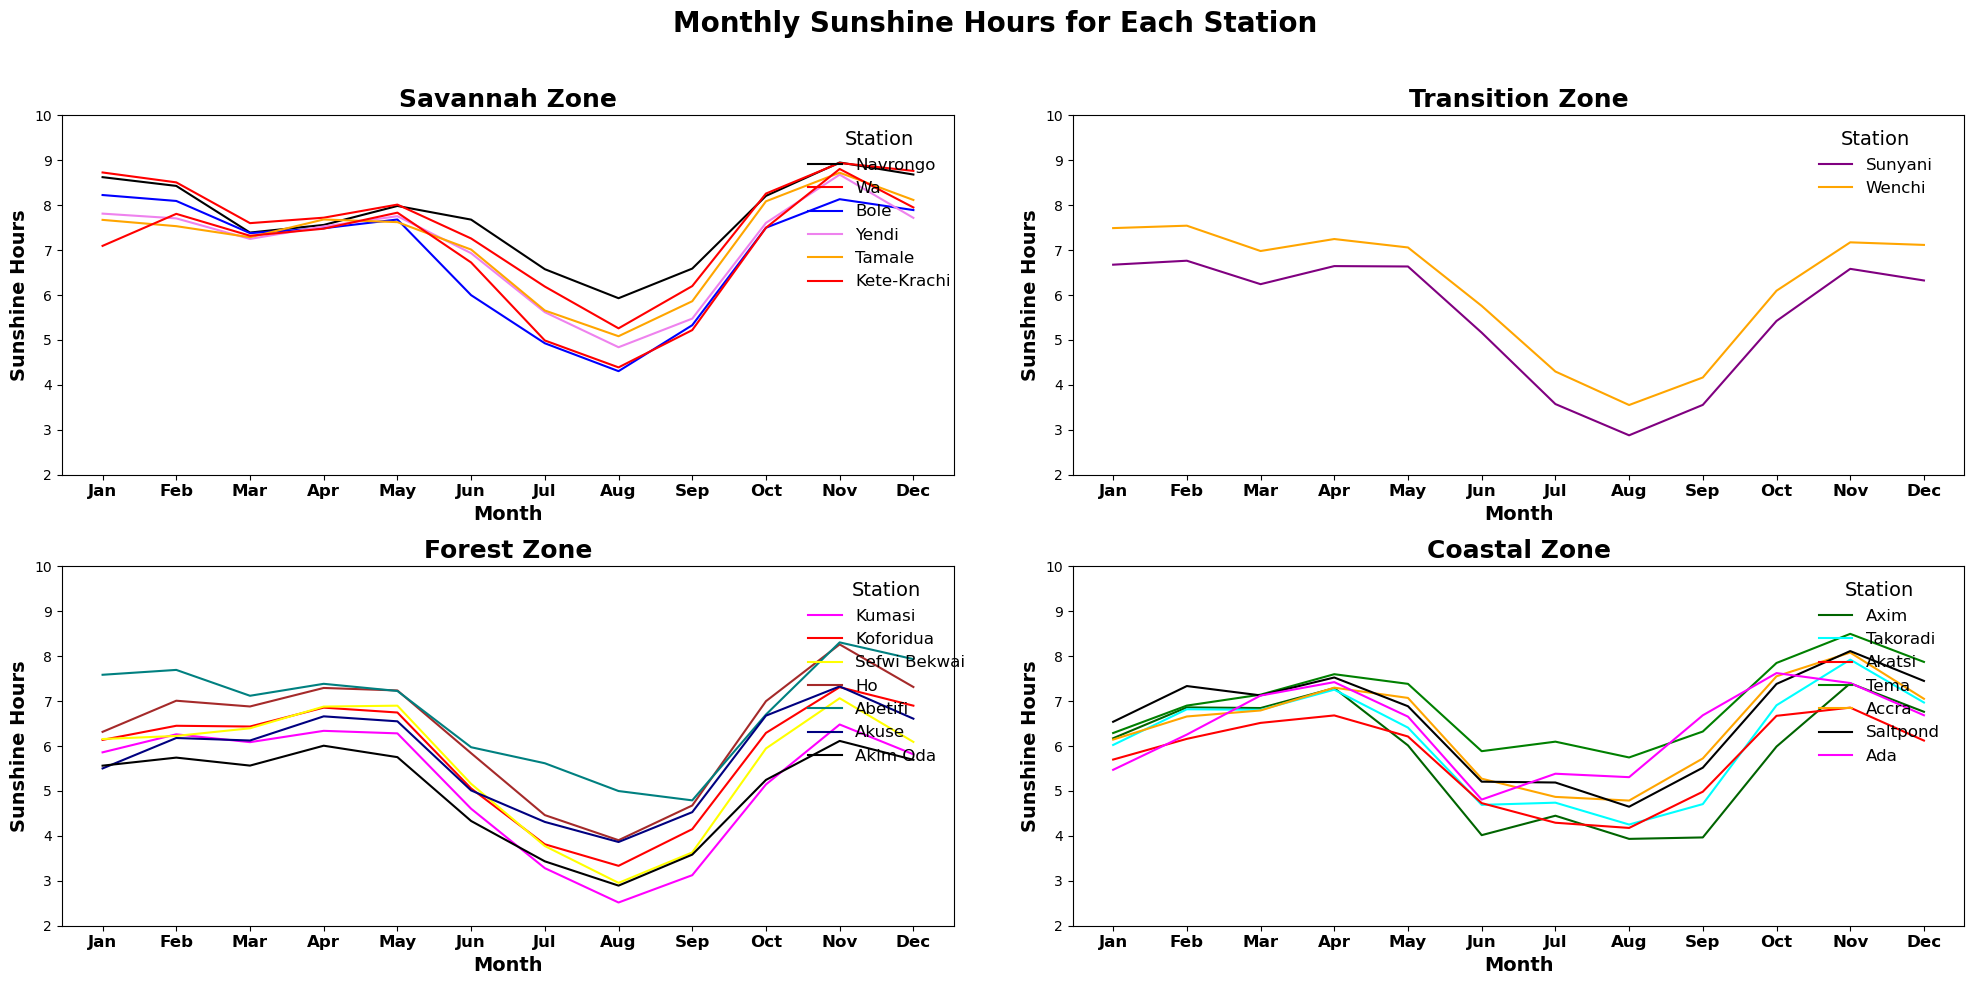

In [2]:
custom_colors = {
    'Sudan Savannah': 'green', 'Wa': 'red', 'Bole': 'blue', 'Yendi': 'violet', 'Tamale': 'orange',
    'Kete-Krachi': 'red', 'Sunyani': 'purple', 'Wenchi': 'orange',
    'Kumasi': 'magenta', 'Koforidua': 'red', 'Sefwi Bekwai': 'yellow', 'Ho': 'brown',
    'Abetifi': 'teal', 'Akuse': 'navy', 'Axim': 'darkgreen', 'Takoradi': 'cyan', 'Akim Oda': 'black',
    'Akatsi': 'red', 'Tema': 'green', 'Accra': 'orange', 'Saltpond': 'black', 'Ada': 'magenta'
}

location_groups = {
    'Savannah': ['Navrongo','Wa', 'Bole', 'Yendi', 'Tamale','Kete-Krachi'],
    'Transition': ['Sunyani', 'Wenchi'],
    'Forest': ['Kumasi', 'Koforidua', 'Sefwi Bekwai', 'Ho', 'Abetifi', 'Akuse', 'Akim Oda'],
    'Coastal': ['Axim', 'Takoradi','Akatsi', 'Tema', 'Accra', 'Saltpond', 'Ada']
}

def melt_and_aggregate(dataset, variable_name):
    dataset['Date'] = pd.to_datetime(dataset['Date'])

    dataset['Year'] = dataset['Date'].dt.year
    dataset['Month'] = dataset['Date'].dt.month

    melted = dataset.melt(id_vars=['Date', 'Year', 'Month'],
                          value_vars=[col for col in dataset.columns if col not in ['Date', 'Year', 'Month']],
                          var_name='Name',
                          value_name=variable_name)

    if variable_name == 'Rainfall':
        num_years = len(melted['Year'].unique())
        aggregated = melted.groupby(['Name', 'Month'])[variable_name].sum().reset_index()
        aggregated[variable_name] = aggregated[variable_name] / num_years 
    else:
        aggregated = melted.groupby(['Name', 'Month'])[variable_name].mean().reset_index()

    return aggregated

rainfall = pd.read_csv('merged_rain.csv')
mean_temp = pd.read_csv('merged_meanT.csv')
rh = pd.read_csv('merged_rh.csv')
#rh.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
sunshine = pd.read_csv('merged_Sunshine.csv')

rainfall_aggregated = melt_and_aggregate(rainfall, 'Rainfall')
temperature_aggregated = melt_and_aggregate(mean_temp, 'Temperature')
rh_aggregated = melt_and_aggregate(rh, 'Relative_Humidity')
sunshine_aggregated = melt_and_aggregate(sunshine, 'Sunshine_Hours')

def plot_time_series_in_zones(df, value_column, title, ylabel, filename, ymin, ymax):
    """
    Function to plot time series for each variable, grouped by zones, with a dynamic subplot grid.
    """
    num_zones = len(location_groups)
    cols = 2
    rows = math.ceil(num_zones / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows), sharey=False)
    axes = axes.flatten()

    for idx, zone in enumerate(location_groups.keys()):
        ax = axes[idx]
        zone_locations = location_groups[zone]

        for location in zone_locations:
            location_data = df[df['Name'] == location]
            ax.plot(location_data['Month'], location_data[value_column],
                    label=location, color=custom_colors.get(location, 'black'))

        ax.set_title(f'{zone} Zone', fontsize=18, fontweight='bold', color='black')
        ax.set_xlabel('Month', fontsize=14, fontweight='bold', color='black')
        ax.set_ylabel(ylabel, fontsize=14, fontweight='bold', color='black')

        ax.set_xticks(np.arange(1, 13))
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                           fontsize=12, fontweight='bold', color='black')

        ax.set_ylim(ymin, ymax)
        ax.legend(title='Station', bbox_to_anchor=(0.82, 1), loc='upper left',
                  fontsize=12, title_fontsize=14, frameon=False)

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title, fontsize=20, fontweight='bold', color='black')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
    plt.savefig(filename)
    plt.show()


rainfall_ymin, rainfall_ymax = 0, 520
temperature_ymin, temperature_ymax = 23, 31
rh_ymin, rh_ymax = 30, 95
sunshine_ymin, sunshine_ymax = 2, 10

plot_time_series_in_zones(rainfall_aggregated, 'Rainfall', 'Monthly Rainfall for Each Station', 'Average Monthly Rainfall (mm)', 'monthly_rainfall_by_zone.png', rainfall_ymin, rainfall_ymax)
plot_time_series_in_zones(temperature_aggregated, 'Temperature', 'Monthly Mean Temperature for Each Station', 'Mean Temperature (°C)', 'monthly_mean_temperature_by_zone.png', temperature_ymin, temperature_ymax)
plot_time_series_in_zones(rh_aggregated, 'Relative_Humidity', 'Monthly Relative Humidity for Each Station', 'Relative Humidity (%)', 'monthly_humidity_by_zone.png', rh_ymin, rh_ymax)
plot_time_series_in_zones(sunshine_aggregated, 'Sunshine_Hours', 'Monthly Sunshine Hours for Each Station', 'Sunshine Hours', 'monthly_sunshine_by_zone.png', sunshine_ymin, sunshine_ymax)


In [3]:
def plot_variables_by_zone_grid(rain_df, temp_df, rh_df, sun_df):
    fig, axes = plt.subplots(4, 4, figsize=(28, 22), sharex=False, sharey=False)

    variable_dfs = {
        'Rainfall': (rain_df, 'Average Monthly Rainfall (mm)', (0, 520)),
        'Temperature': (temp_df, 'Mean Temperature (°C)', (23, 31)),
        'Relative_Humidity': (rh_df, 'Relative Humidity (%)', (30, 95)),
        'Sunshine_Hours': (sun_df, 'Sunshine Hours', (2, 10)),
    }

    zones = list(location_groups.keys())
    variables = list(variable_dfs.keys())

    for row_idx, var_name in enumerate(variables):
        df, ylabel, (ymin, ymax) = variable_dfs[var_name]

        for col_idx, zone in enumerate(zones):
            ax = axes[row_idx, col_idx]
            zone_locations = location_groups[zone]

            zone_df = df[df['Name'].isin(zone_locations)]

            for location in zone_locations:
                loc_data = zone_df[zone_df['Name'] == location]
                ax.plot(
                    loc_data['Month'], loc_data[var_name],
                    label=location,
                    color=custom_colors.get(location, 'black'),
                    linewidth=1.5
                )
            mean_by_month = zone_df.groupby('Month')[var_name].mean()
            ax.plot(
                mean_by_month.index, mean_by_month.values,
                color='black', linewidth=4, label='Zone Mean'
            )

            ax.set_ylim(ymin, ymax)
            ax.set_xticks(np.arange(1, 13))
            ax.set_xticklabels(
                ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                fontsize=12, rotation=0, fontweight='bold', color='black'
            )

            if row_idx == 0:
                ax.set_title(f'{zone} Zone', fontsize=18, fontweight='bold', color='black')
                ax.legend(fontsize=12,frameon=True,loc='upper right',handlelength=2,labelspacing=0.3,borderpad=0.5)
            if col_idx == 0:
                ax.set_ylabel(f'{ylabel}', fontsize=16, fontweight='bold', color='black')

            ax.tick_params(axis='both', which='major', labelsize=12, labelcolor='black', width=1.5)

#            ax.grid(True, linestyle='--', alpha=0.4)

            # Legend inside each subplot
#            ax.legend(fontsize=10,frameon=False,loc='upper right',handlelength=2,labelspacing=0.3,borderpad=0.5)


    fig.text(0.5, 0.04, 'Month', ha='center', fontsize=18, fontweight='bold', color='black')

    plt.tight_layout(rect=[0, 0.05, 1, 0.94])
    plt.suptitle(
        "Monthly Climate Variables Across the Zones in Ghana",
        fontsize=24, fontweight='bold', color='black'
    )
    plt.savefig('Monthly Climate Variables Across the Zones in Ghana.png', dpi=300)
    plt.show()


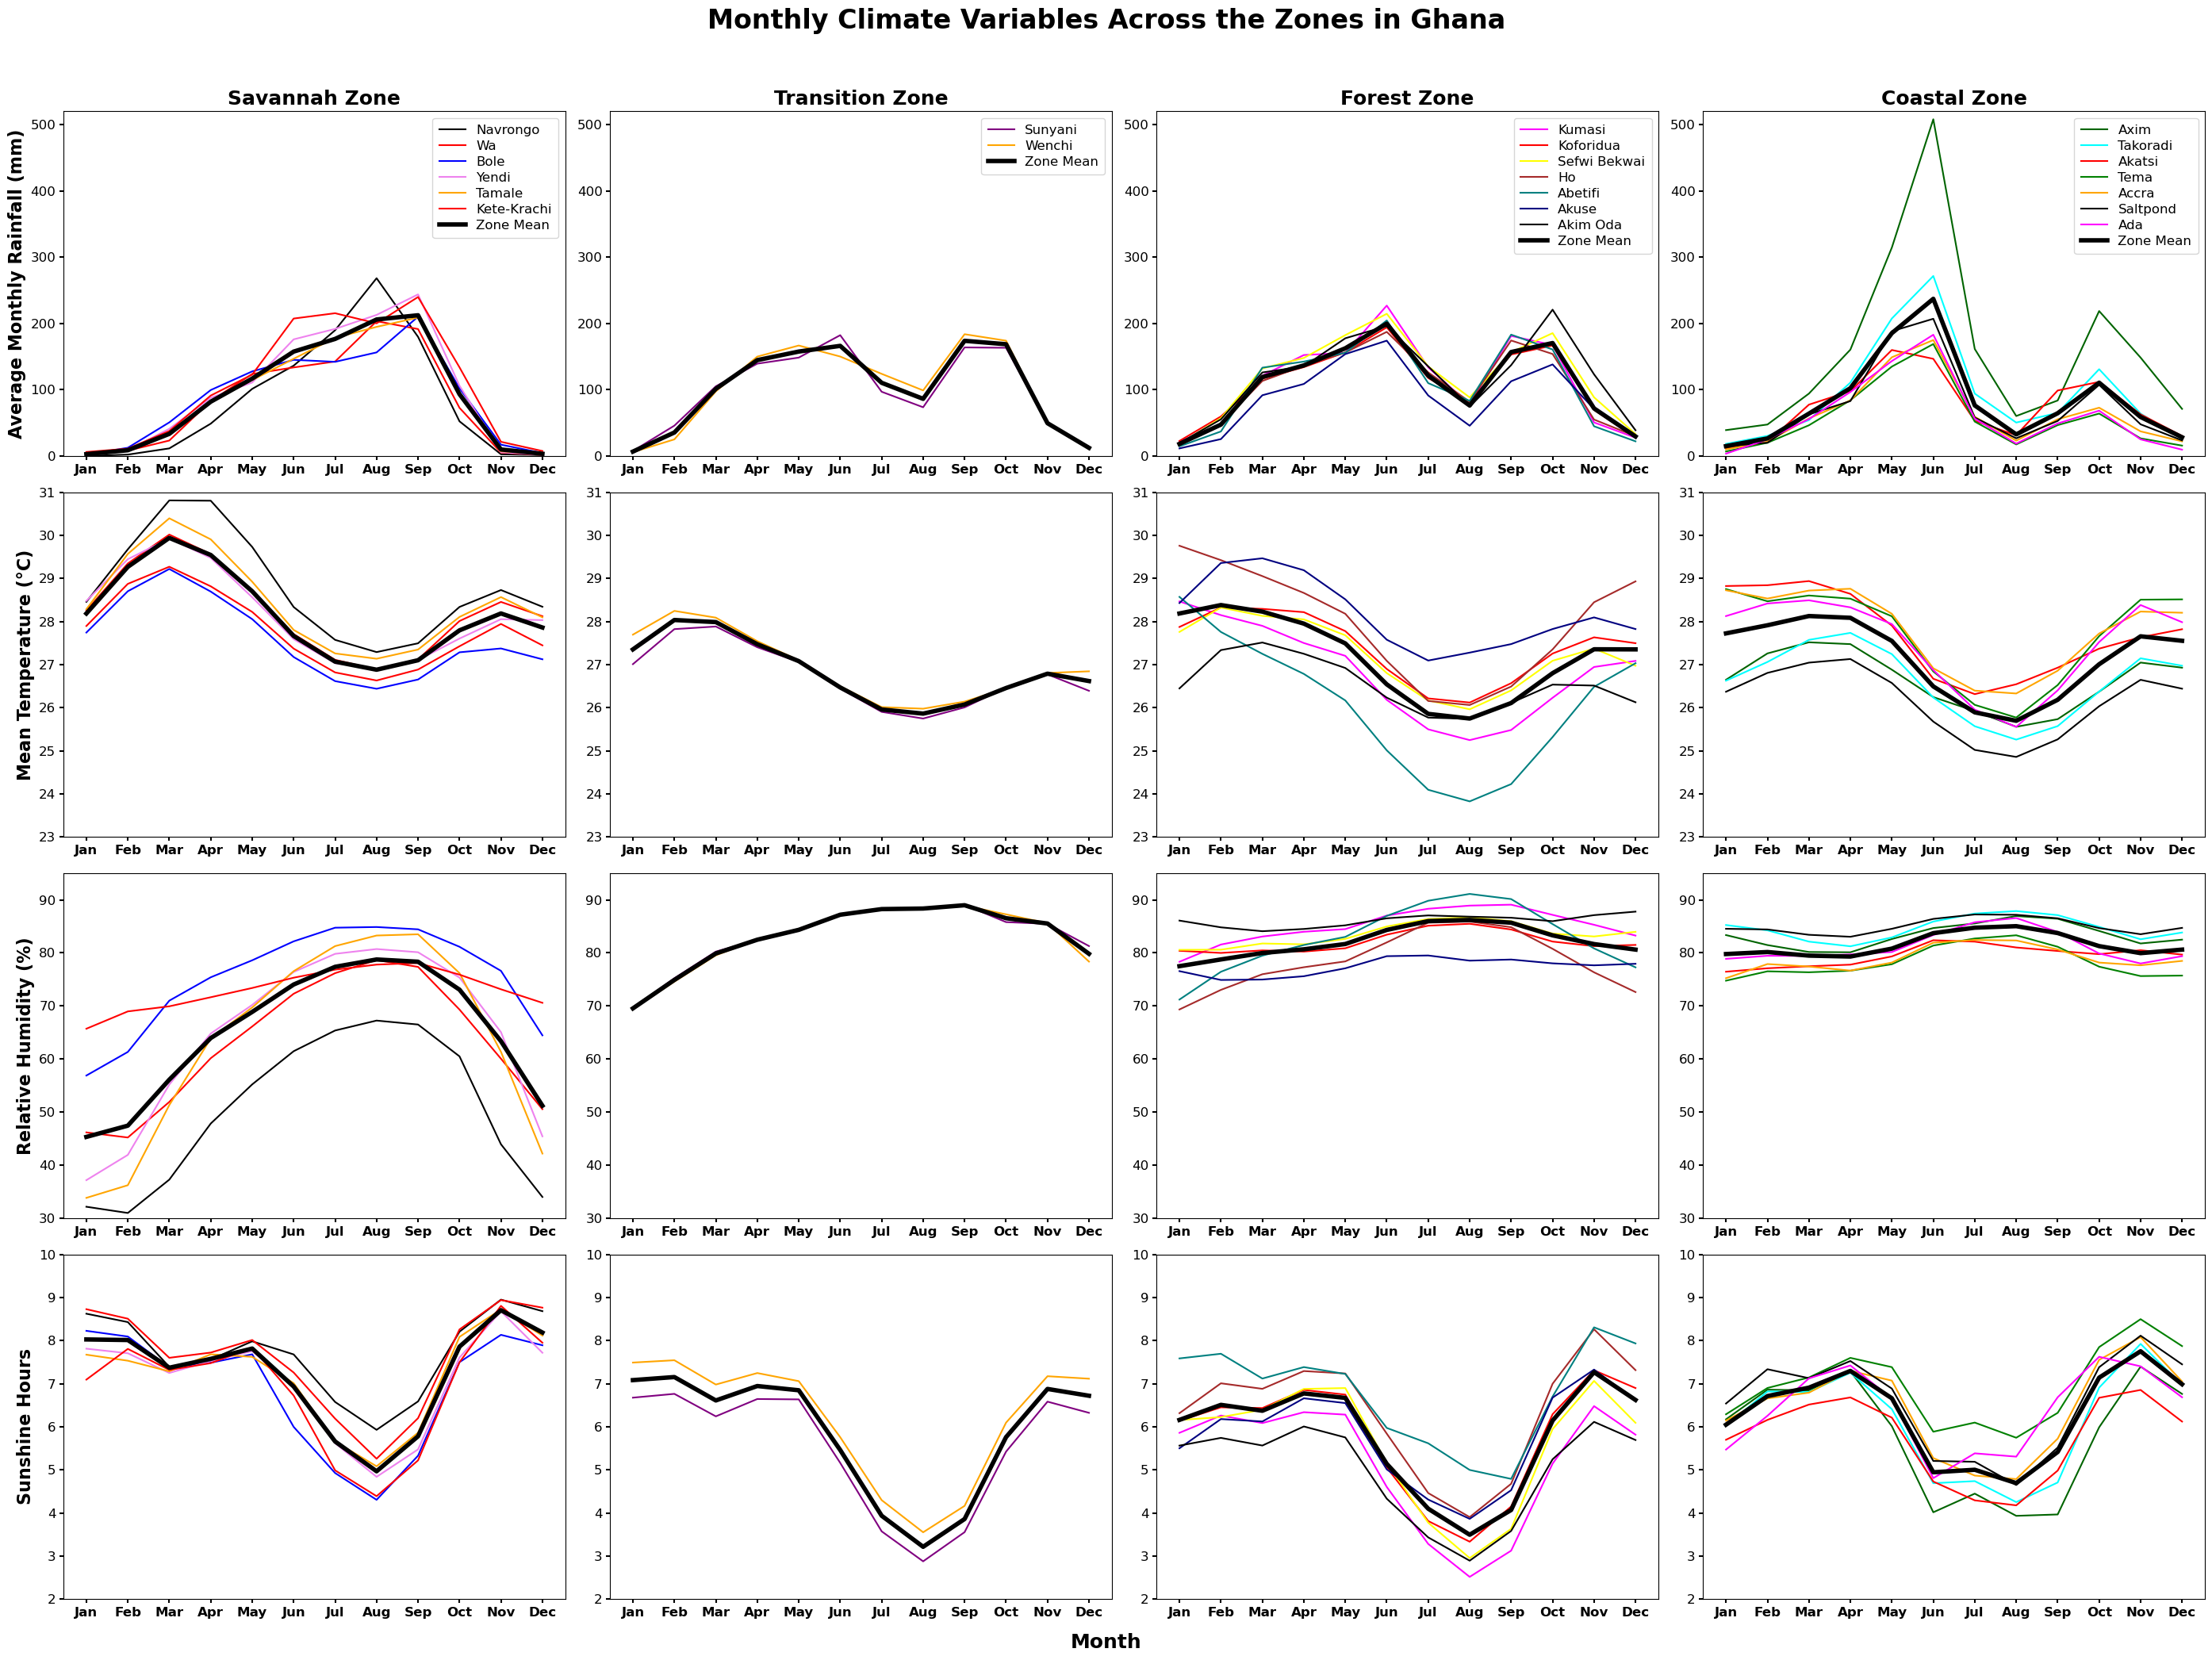

In [4]:
plot_variables_by_zone_grid(
    rainfall_aggregated,
    temperature_aggregated,
    rh_aggregated,
    sunshine_aggregated
)


## zonal means

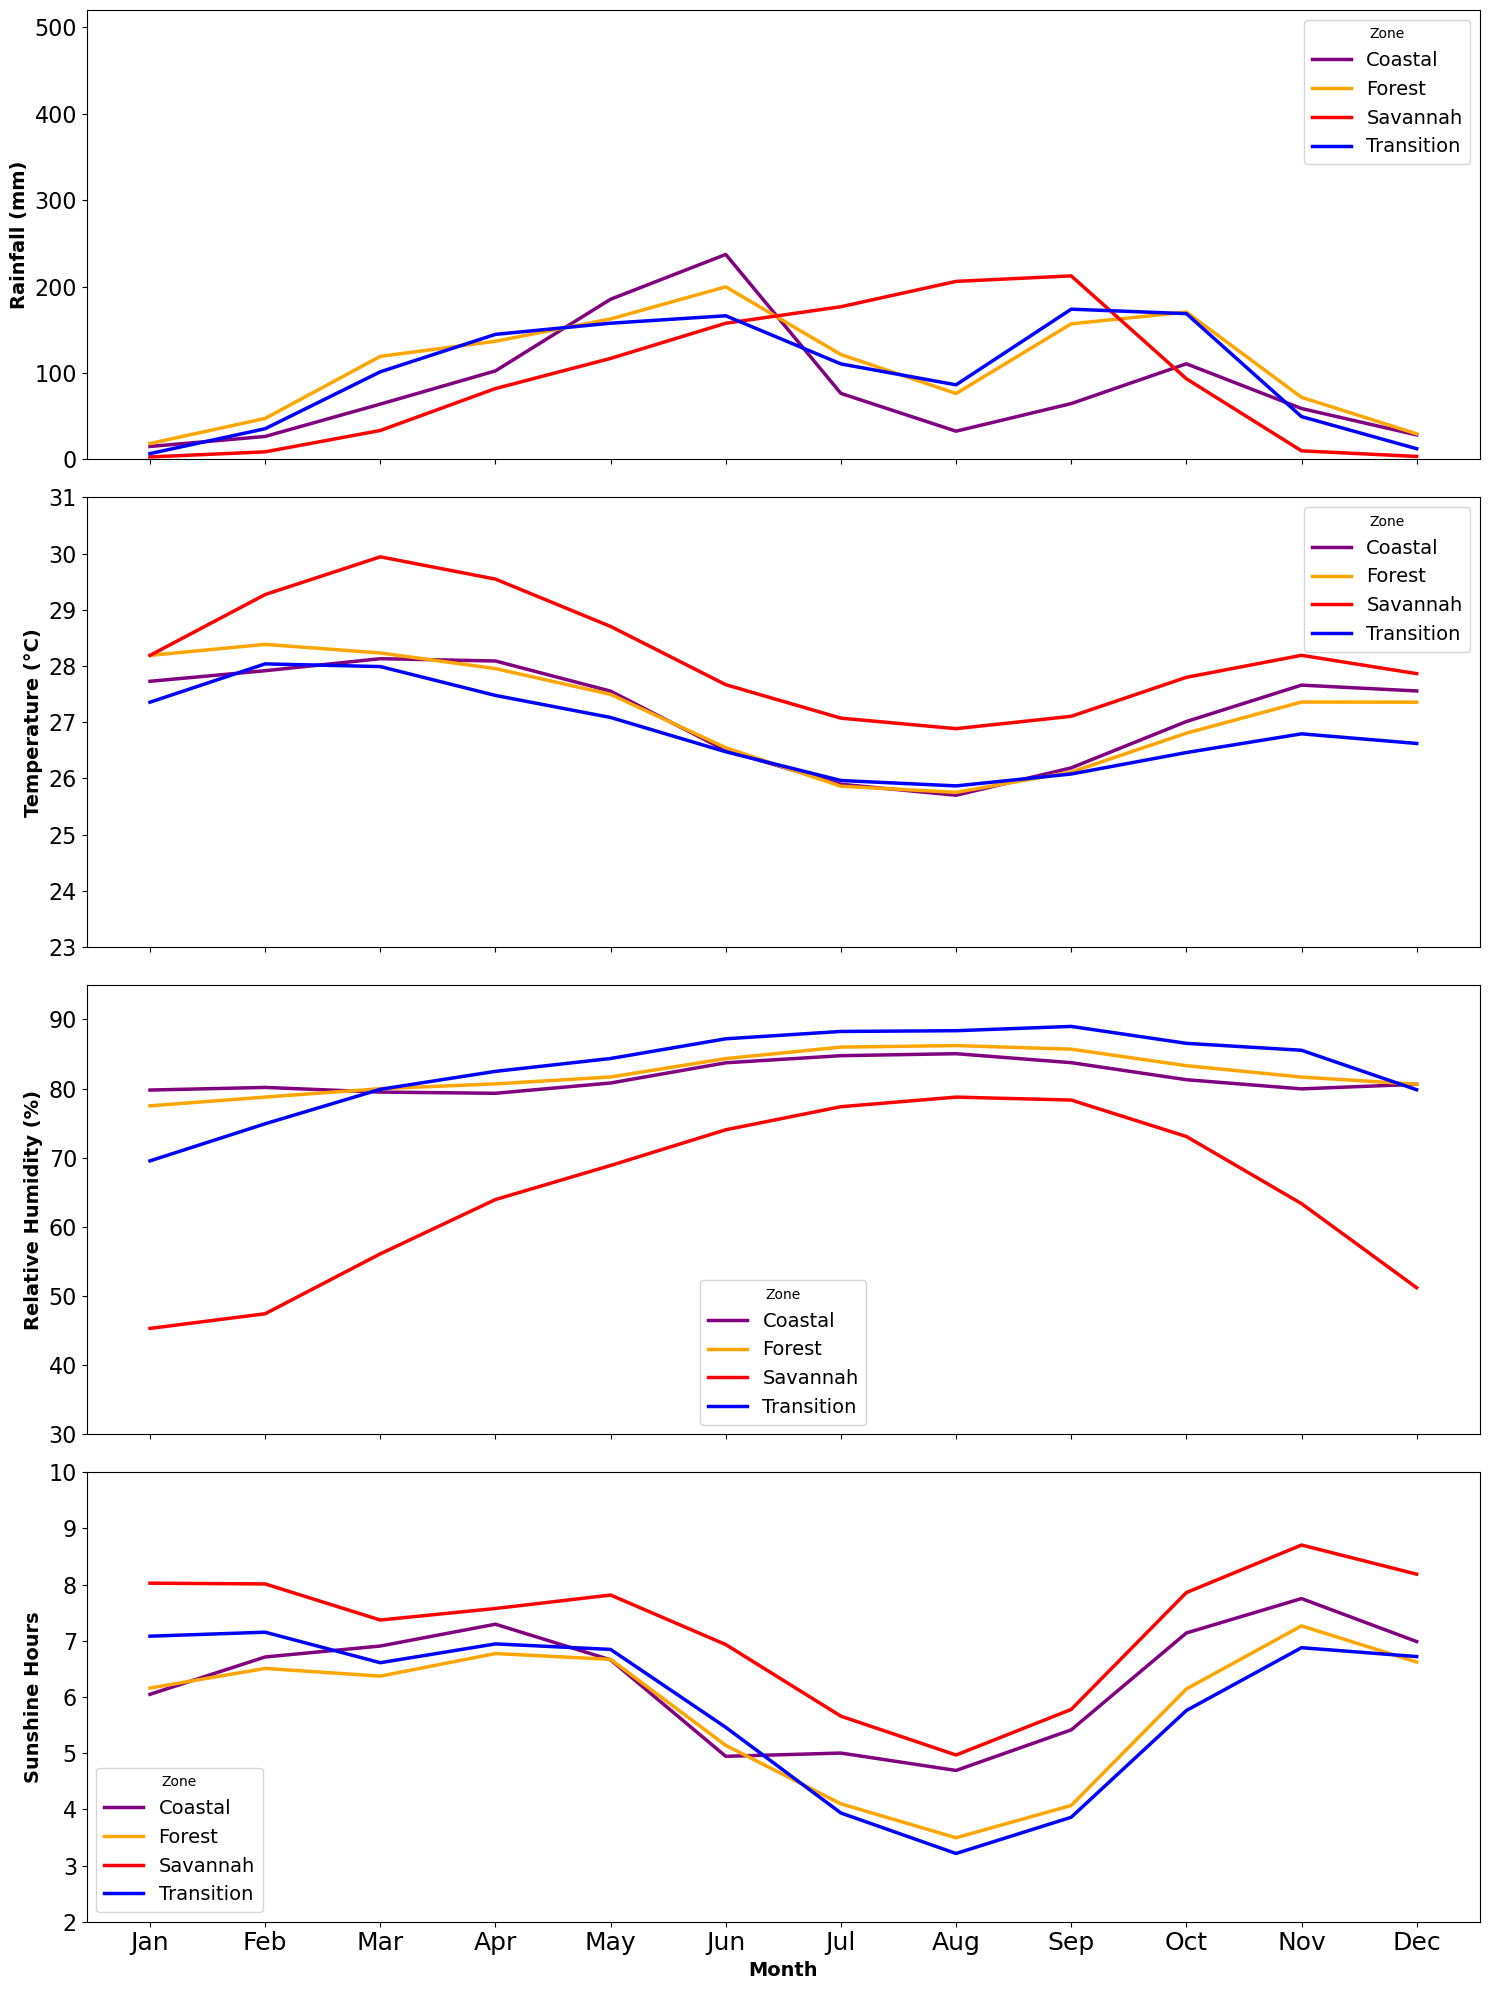

In [5]:
# Step 1: Invert the location_groups dict to map station to zone
station_to_zone = {}
for zone, stations in location_groups.items():
    for station in stations:
        station_to_zone[station] = zone

# Step 2: a function to aggregate by zone
def aggregate_by_zone(df, value_column):
    df = df.copy()
    df['Zone'] = df['Name'].map(station_to_zone)
    aggregated_zone = df.groupby(['Zone', 'Month'])[value_column].mean().reset_index()
    return aggregated_zone

# Step 3: zone aggregation to all datasets
rainfall_zone = aggregate_by_zone(rainfall_aggregated, 'Rainfall')
temperature_zone = aggregate_by_zone(temperature_aggregated, 'Temperature')
rh_zone = aggregate_by_zone(rh_aggregated, 'Relative_Humidity')
sunshine_zone = aggregate_by_zone(sunshine_aggregated, 'Sunshine_Hours')

# Step 4: subplot-based zone-level plotting function
def plot_all_zone_variables(rainfall_zone, temperature_zone, rh_zone, sunshine_zone):
    fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=True)
    variables = [
        (rainfall_zone, 'Rainfall', 'Rainfall (mm)', (0, 520)),
        (temperature_zone, 'Temperature', 'Temperature (°C)', (23, 31)),
        (rh_zone, 'Relative_Humidity', 'Relative Humidity (%)', (30, 95)),
        (sunshine_zone, 'Sunshine_Hours', 'Sunshine Hours', (2, 10))
    ]

    zone_colors = {
        'Savannah': 'red',
        'Transition': 'blue',
        'Forest': 'orange',
        'Coastal': 'purple'
    }

    for ax, (df, col, ylabel, (ymin, ymax)) in zip(axes, variables):
        for zone in df['Zone'].unique():
            zone_data = df[df['Zone'] == zone]
            ax.plot(zone_data['Month'], zone_data[col],
                    label=zone, linewidth=2.5, color=zone_colors.get(zone, 'black'))

        ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
        ax.set_ylim(ymin, ymax)
        ax.tick_params(axis='y', labelsize=16)  # Increase y-axis tick size
#        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend(title='Zone', fontsize=14)
        ax.set_xticks(np.arange(1, 13))
        ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=18)

#    axes[0].set_title('Monthly Mean Climate Variables by Zone', fontsize=20, fontweight='bold')
    axes[-1].set_xlabel('Month', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('zone_variables_subplot.png')
    plt.show()

plot_all_zone_variables(rainfall_zone, temperature_zone, rh_zone, sunshine_zone)

In [6]:
print(rainfall.columns)
#print(minmax_temp.columns)
print(rh.columns)
print(sunshine.columns)

Index(['Date', 'Abetifi', 'Accra', 'Ada', 'Akatsi', 'Akim Oda', 'Akuse',
       'Axim', 'Bole', 'Ho', 'Kete-Krachi', 'Koforidua', 'Kumasi', 'Navrongo',
       'Saltpond', 'Sefwi Bekwai', 'Sunyani', 'Takoradi', 'Tamale', 'Tema',
       'Wa', 'Wenchi', 'Yendi', 'Year', 'Month'],
      dtype='object')
Index(['Unnamed: 0', 'Date', 'Navrongo', 'Wa', 'Bole', 'Yendi', 'Tamale',
       'Kete-Krachi', 'Sunyani', 'Wenchi', 'Kumasi', 'Koforidua',
       'Sefwi Bekwai', 'Ho', 'Abetifi', 'Akuse', 'Axim', 'Takoradi',
       'Akim Oda', 'Akatsi', 'Tema', 'Accra', 'Saltpond', 'Ada', 'Year',
       'Month'],
      dtype='object')
Index(['Date', 'Abetifi', 'Accra', 'Ada', 'Akatsi', 'Akim Oda', 'Akuse',
       'Axim', 'Bole', 'Ho', 'Kete-Krachi', 'Koforidua', 'Kumasi', 'Navrongo',
       'Saltpond', 'Sefwi Bekwai', 'Sunyani', 'Takoradi', 'Tamale', 'Tema',
       'Wa', 'Wenchi', 'Yendi', 'Year', 'Month'],
      dtype='object')


In [7]:
# GROUPING THE data into yearly monthly mean

df_Temp=pd.read_excel('Min_and_Max_Temp.xlsx')
df_Temp['Tm']=df_Temp.iloc[:,4:].mean(axis=1)
df_RH=pd.read_excel('Relative_Humidity.xlsx')
df_RH['RH_mean']=df_RH.iloc[:,4:].mean(axis=1)
df_Rain=pd.read_excel('Rainfall.xlsx')
df_Rain['Rain_sum']=df_Rain.iloc[:,4:].sum(axis=1)
df_Sunshine=pd.read_excel('Sunshine_Hours.xlsx')
df_Sunshine['Sunshine_mean']=df_Sunshine.iloc[:,4:].mean(axis=1)

In [8]:
df_Rain.max()

Name                   Yendi
Eg El Abbreviation        RR
Year                    2023
Month                     12
DAY 1                  196.3
DAY 2                  261.9
DAY 3                  243.9
DAY 4                  214.7
DAY 5                  209.5
DAY 6                  166.9
DAY 7                  160.4
DAY 8                  219.9
DAY 9                  204.0
DAY 10                 151.5
DAY 11                 147.2
DAY 12                 205.7
DAY 13                 163.3
DAY 14                 169.7
DAY 15                 150.5
DAY 16                 191.5
DAY 17                 115.8
DAY 18                 151.0
DAY 19                 150.6
DAY 20                 154.2
DAY 21                 190.5
DAY 22                 137.3
DAY 23                 355.4
DAY 24                 163.2
DAY 25                 137.5
DAY 26                 119.7
DAY 27                 165.4
DAY 28                 143.0
DAY 29                 166.8
DAY 30                 149.0
DAY 31        

In [9]:
df_Sunshine.iloc[500:560]

Name Eg El Abbreviation  Year  Month  DAY 1  DAY 2  DAY 3  DAY 4  \
500        Kumasi              SUNHR  1983      5    6.5    2.5    7.4    4.8   
501        Kumasi              SUNHR  1983      6    5.7    5.9    0.5    3.4   
502        Kumasi              SUNHR  1983      7    2.0    3.9    4.5    1.0   
503        Kumasi              SUNHR  1983      8    5.5    5.0    2.2    1.8   
504        Kumasi              SUNHR  1983      9    1.7    0.2    2.8    3.0   
505        Kumasi              SUNHR  1983     10    6.1    6.8    3.8    4.3   
506        Kumasi              SUNHR  1983     11    7.0    7.9    6.3    7.6   
507        Kumasi              SUNHR  1983     12    2.7    3.2    0.0    NaN   
508      Navrongo              SUNHR  1983      1    8.8    9.8    7.2    7.3   
509      Navrongo              SUNHR  1983      2    9.5    8.8    9.2   10.0   
510      Navrongo              SUNHR  1983      3    0.0    3.9    5.7    8.3   
511      Navrongo              SUNHR  1983      4    5.1    0.0    0.4    9.0   
512      Navrongo              SUNHR  1983      5    6.8    0.2    8.9    8.0   
513      Navrongo              SUNHR  1983      6    0.3   10.5    2.9    7.8   
514      Navrongo              SUNHR  1983      7   11.1   11.3    4.4    7.6   
515      Navrongo              SUNHR  1983      8    5.7   10.3   10.6    0.0   
516      Navrongo              SUNHR  1983      9    9.6    5.5   10.1    8.8   
517      Navrongo              SUNHR  1983     10   10.0    9.8    9.8    9.4   
518      Navrongo              SUNHR  1983     11   10.2    7.9    8.2    8.3   
519      Navrongo              SUNHR  1983     12    8.8    8.7    8.8    6.2   
520      Saltpond              SUNHR  1983      1    7.0    6.3    6.2    4.0   
521      Saltpond              SUNHR  1983      2    3.1    2.8    3.8    5.1   
522      Saltpond              SUNHR  1983      3    2.2    0.0    2.1    0.5   
523      Saltpond              SUNHR  1983      4    0.7    8.8    0.8    9.1   
524      Saltpond              SUNHR  1983      5    8.9    0.7    1.2    9.6   
525      Saltpond              SUNHR  1983      6    9.0    8.3    1.8    3.7   
526      Saltpond              SUNHR  1983      7    8.5    7.8    5.0    7.7   
527      Saltpond              SUNHR  1983      8    8.7    7.1    3.9    5.5   
528      Saltpond              SUNHR  1983      9    5.5    0.9    9.8    8.1   
529      Saltpond              SUNHR  1983     10    8.1    5.9    7.3    7.8   
530      Saltpond              SUNHR  1983     11    9.1    8.5    9.7    8.8   
531      Saltpond              SUNHR  1983     12    5.4    5.2    8.8    9.3   
532  Sefwi Bekwai              SUNHR  1983      1    4.0    0.0    5.8    5.7   
533  Sefwi Bekwai              SUNHR  1983      2    6.4    5.3    5.0    5.0   
534  Sefwi Bekwai              SUNHR  1983      3    0.7    0.0    3.9    0.0   
535  Sefwi Bekwai              SUNHR  1983      4    7.1    5.3    0.4    3.3   
536  Sefwi Bekwai              SUNHR  1983      5    7.7    1.5    5.2    6.8   
537  Sefwi Bekwai              SUNHR  1983      6    6.3    7.7    0.0    0.7   
538  Sefwi Bekwai              SUNHR  1983      7    3.7    4.1    2.4    2.1   
539  Sefwi Bekwai              SUNHR  1983      8    4.5    4.9    2.4    2.0   
540  Sefwi Bekwai              SUNHR  1983      9    1.9    0.4    2.5    1.3   
541  Sefwi Bekwai              SUNHR  1983     10    7.5    5.7    5.6    4.8   
542  Sefwi Bekwai              SUNHR  1983     11    7.2    8.2    7.5    8.1   
543  Sefwi Bekwai              SUNHR  1983     12    3.7    5.6    5.2    6.5   
544       Sunyani              SUNHR  1983      1    5.4    6.9    8.0    7.0   
545       Sunyani              SUNHR  1983      2    5.6    5.0    6.2    5.1   
546       Sunyani              SUNHR  1983      3    0.0    0.0    6.5    2.1   
547       Sunyani              SUNHR  1983      4    7.4    4.3    0.0    9.8   
548       Sunyani              SUNHR  1983  

In [10]:
df_Temp.columns

Index(['Name', 'Eg El Abbreviation', 'Year', 'Month', 'DAY 1', 'DAY 2',
       'DAY 3', 'DAY 4', 'DAY 5', 'DAY 6', 'DAY 7', 'DAY 8', 'DAY 9', 'DAY 10',
       'DAY 11', 'DAY 12', 'DAY 13', 'DAY 14', 'DAY 15', 'DAY 16', 'DAY 17',
       'DAY 18', 'DAY 19', 'DAY 20', 'DAY 21', 'DAY 22', 'DAY 23', 'DAY 24',
       'DAY 25', 'DAY 26', 'DAY 27', 'DAY 28', 'DAY 29', 'DAY 30', 'DAY 31',
       'Tm'],
      dtype='object')

In [11]:
## selecting variables we want to use from the datasets
Temp=df_Temp[['Name','Year','Eg El Abbreviation','Month','Tm']]
RH=df_RH[['Name','Year','Eg El Abbreviation','Month','RH_mean']]
Rain=df_Rain[['Name','Year','Eg El Abbreviation','Month','Rain_sum']]
Sunshine=df_Sunshine[['Name','Year','Eg El Abbreviation','Month','Sunshine_mean']]

## converting them to a datetime
Temp['Date']= pd.to_datetime(Temp[['Year','Month']].assign(day=1))
RH['Date']= pd.to_datetime(RH[['Year','Month']].assign(day=1))
Rain['Date']= pd.to_datetime(Rain[['Year','Month']].assign(day=1))
Sunshine['Date']= pd.to_datetime(Sunshine[['Year','Month']].assign(day=1))

/tmp/ipykernel_29822/326000340.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temp['Date']= pd.to_datetime(Temp[['Year','Month']].assign(day=1))
/tmp/ipykernel_29822/326000340.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RH['Date']= pd.to_datetime(RH[['Year','Month']].assign(day=1))
/tmp/ipykernel_29822/326000340.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [12]:
Temp.drop(columns=['Year','Month'], axis=1)

Name Eg El Abbreviation         Tm       Date
0      Abetifi                 Tn  20.790323 1981-01-01
1      Abetifi                 Tn  21.471429 1981-02-01
2      Abetifi                 Tn  21.167742 1981-03-01
3      Abetifi                 Tn  21.483333 1981-04-01
4      Abetifi                 Tn  20.661290 1981-05-01
...        ...                ...        ...        ...
16378   Tamale                 Tx  32.806667 2002-06-01
16379   Tamale                 Tx  31.064516 2002-07-01
16380   Tamale                 Tx  29.903226 2002-08-01
16381   Tamale                 Tx  31.280000 2002-09-01
16382   Tamale                 Tx  33.590323 2002-10-01

[16383 rows x 4 columns]

In [13]:
minT= Temp[Temp['Eg El Abbreviation']=='Tn'].drop(['Eg El Abbreviation','Year','Month'], axis=1)
maxT=Temp[Temp['Eg El Abbreviation']=='Tx'].drop(['Eg El Abbreviation','Year','Month'], axis=1)

RH= RH.drop(['Eg El Abbreviation','Year','Month'], axis=1)
Rain= Rain.drop(['Eg El Abbreviation','Year','Month'], axis=1)
Sunshine=Sunshine.drop(['Eg El Abbreviation','Year','Month'], axis=1)

In [14]:
Rain

Name  Rain_sum       Date
0      Abetifi       0.5 1981-01-01
1      Abetifi      83.0 1981-02-01
2      Abetifi      92.0 1981-03-01
3      Abetifi      71.1 1981-04-01
4      Abetifi     120.1 1981-05-01
...        ...       ...        ...
11236    Yendi     331.1 2023-07-01
11237    Yendi     232.8 2023-08-01
11238    Yendi     222.8 2023-09-01
11239    Yendi     171.6 2023-10-01
11240    Yendi      12.4 2023-11-01

[11241 rows x 3 columns]

In [15]:
minT_pivot=minT.pivot(index='Date', columns='Name', values = 'Tm')
maxT_pivot=maxT.pivot(index='Date', columns='Name', values = 'Tm')

RH_pivot=RH.pivot(index='Date', columns='Name', values = 'RH_mean')
Rain_pivot=Rain.pivot(index='Date', columns='Name', values = 'Rain_sum')
Sunshine_pivot=Sunshine.pivot(index='Date', columns='Name', values = 'Sunshine_mean')

In [16]:
RH_pivot

Name          Abetifi      Accra  Ada     Akatsi   Akim Oda      Akuse  Axim  \
Date                                                                           
1983-09-01        NaN        NaN  NaN        NaN        NaN  73.633333   NaN   
1983-11-01        NaN        NaN  NaN        NaN        NaN  73.600000   NaN   
1983-12-01        NaN        NaN  NaN        NaN        NaN  79.600000   NaN   
1984-01-01        NaN        NaN  NaN        NaN        NaN  80.433333   NaN   
1984-02-01        NaN        NaN  NaN        NaN        NaN  65.448276   NaN   
...               ...        ...  ...        ...        ...        ...   ...   
2023-08-01  94.333333  85.033333  NaN  86.266667  91.933333  92.100000   NaN   
2023-09-01  90.066667  82.433333  NaN  83.533333  90.600000  94.233333   NaN   
2023-10-01  83.566667  73.000000  NaN  82.600000  88.833333  81.466667   NaN   
2023-11-01  76.366667  76.300000  NaN  80.100000  89.166667  79.633333   NaN   
2023-12-01  64.800000  73.000000  NaN  75.366667  87.833333  78.900000   NaN   

Name             Bole         Ho  Kete-Krachi  ...   Navrongo   Saltpond  \
Date                                           ...                         
1983-09-01        NaN        NaN          NaN  ...        NaN        NaN   
1983-11-01        NaN        NaN          NaN  ...        NaN        NaN   
1983-12-01        NaN        NaN          NaN  ...        NaN        NaN   
1984-01-01        NaN        NaN          NaN  ...        NaN        NaN   
1984-02-01        NaN        NaN          NaN  ...        NaN        NaN   
...               ...        ...          ...  ...        ...        ...   
2023-08-01  87.800000  87.433333    88.900000  ...  87.700000  93.933333   
2023-09-01  85.166667  85.800000    87.333333  ...  84.233333  88.666667   
2023-10-01  80.666667  79.400000    85.133333  ...  78.766667  85.900000   
2023-11-01  74.233333  74.333333    77.366667  ...  59.400000  84.366667   
2023-12-01  41.566667  66.300000    67.166667  ...  37.400000  83.266667   

Name        Sefwi Bekwai    Sunyani   Takoradi     Tamale       Tema  \
Date                                                                   
1983-09-01           NaN        NaN        NaN        NaN        NaN   
1983-11-01           NaN        NaN        NaN        NaN        NaN   
1983-12-01           NaN        NaN        NaN        NaN        NaN   
1984-01-01           NaN        NaN        NaN        NaN        NaN   
1984-02-01           NaN        NaN        NaN        NaN        NaN   
...                  ...        ...        ...        ...        ...   
2023-08-01     90.766667  89.533333  91.800000  85.033333  85.800000   
2023-09-01     88.233333  89.166667  89.200000  81.133333  83.633333   
2023-10-01     85.300000  86.333333  87.233333  79.433333  77.900000   
2023-11-01     83.066667  84.166667  83.766667  68.500000  74.733333   
2023-12-01     80.133333  70.933333  81.100000  46.500000  71.433333   

Name               Wa     Wenchi      Yendi  
Date                                         
1983-09-01        NaN        NaN        NaN  
1983-11-01        NaN        NaN        NaN  
1983-12-01        NaN        NaN        NaN  
1984-01-01        NaN        NaN        NaN  
1984-02-01        NaN        NaN        NaN  
...               ...        ...        ...  
2023-08-01  86.133333  87.433333  88.666667  
2023-09-01  81.200000  84.533333  85.166667  
2023-10-01  76.600000        NaN  83.133333  
2023-11-01  63.233333  84.533333  74.200000  
2023-12-01  32.933333  61.600000        NaN  

[474 rows x 22 columns]

In [17]:

RH_2=RH_pivot[RH_pivot.index.year <= 2000]
minT_2=minT_pivot[minT_pivot.index.year <= 2000]
maxT_2=maxT_pivot[maxT_pivot.index.year <= 2000]
Rain_2=Rain_pivot#[Rain_pivot.index.year <= 2000]

In [18]:
RH_2

Name          Abetifi      Accra        Ada     Akatsi   Akim Oda      Akuse  \
Date                                                                           
1983-09-01        NaN        NaN        NaN        NaN        NaN  73.633333   
1983-11-01        NaN        NaN        NaN        NaN        NaN  73.600000   
1983-12-01        NaN        NaN        NaN        NaN        NaN  79.600000   
1984-01-01        NaN        NaN        NaN        NaN        NaN  80.433333   
1984-02-01        NaN        NaN        NaN        NaN        NaN  65.448276   
...               ...        ...        ...        ...        ...        ...   
2000-08-01  91.300000  82.800000  88.433333  83.733333  87.433333        NaN   
2000-09-01  91.233333  79.800000  82.533333  77.300000  87.266667        NaN   
2000-10-01  85.566667  75.000000  76.466667  76.900000  84.700000        NaN   
2000-11-01  79.433333  77.633333  77.066667  82.300000  87.466667        NaN   
2000-12-01  75.166667  81.066667  78.666667  82.033333  89.466667        NaN   

Name        Axim  Bole         Ho  Kete-Krachi  ...   Navrongo  Saltpond  \
Date                                            ...                        
1983-09-01   NaN   NaN        NaN          NaN  ...        NaN       NaN   
1983-11-01   NaN   NaN        NaN          NaN  ...        NaN       NaN   
1983-12-01   NaN   NaN        NaN          NaN  ...        NaN       NaN   
1984-01-01   NaN   NaN        NaN          NaN  ...        NaN       NaN   
1984-02-01   NaN   NaN        NaN          NaN  ...        NaN       NaN   
...          ...   ...        ...          ...  ...        ...       ...   
2000-08-01   NaN   NaN  87.200000          NaN  ...  84.366667       NaN   
2000-09-01   NaN   NaN  86.500000          NaN  ...  83.500000       NaN   
2000-10-01   NaN   NaN  80.766667          NaN  ...  72.400000       NaN   
2000-11-01   NaN   NaN  76.066667          NaN  ...  43.466667       NaN   
2000-12-01   NaN   NaN  70.866667          NaN  ...  31.766667       NaN   

Name        Sefwi Bekwai    Sunyani   Takoradi     Tamale       Tema  Wa  \
Date                                                                       
1983-09-01           NaN        NaN        NaN        NaN        NaN NaN   
1983-11-01           NaN        NaN        NaN        NaN        NaN NaN   
1983-12-01           NaN        NaN        NaN        NaN        NaN NaN   
1984-01-01           NaN        NaN        NaN        NaN        NaN NaN   
1984-02-01           NaN        NaN        NaN        NaN        NaN NaN   
...                  ...        ...        ...        ...        ...  ..   
2000-08-01           NaN  91.266667  89.800000  83.366667  87.200000 NaN   
2000-09-01     87.300000  91.200000  87.633333  84.966667  79.133333 NaN   
2000-10-01           NaN  89.500000  83.466667  76.300000  74.166667 NaN   
2000-11-01     82.600000  89.166667  78.866667  64.900000  74.766667 NaN   
2000-12-01     85.433333  81.466667  87.400000  27.200000  77.966667 NaN   

Name           Wenchi      Yendi  
Date                              
1983-09-01        NaN        NaN  
1983-11-01        NaN        NaN  
1983-12-01        NaN        NaN  
1984-01-01        NaN        NaN  
1984-02-01        NaN        NaN  
...               ...        ...  
2000-08-01  89.266667  89.166667  
2000-09-01  90.500000  86.300000  
2000-10-01  87.500000  80.000000  
2000-11-01  87.533333  70.966667  
2000-12-01  69.900000  36.366667  

[198 rows x 22 columns]

In [19]:
meanTemperature=(minT_2+maxT_2)/2
meanTemperature

Name          Abetifi      Accra        Ada     Akatsi   Akim Oda      Akuse  \
Date                                                                           
1981-01-01  25.051613  27.919355  27.954839  28.066129  25.872581  27.641935   
1981-02-01  25.801786  28.662500  29.496429  29.107143  27.898214  29.628571   
1981-03-01  25.685484  28.751613  29.133871  29.170968  27.724194  29.654839   
1981-04-01  25.563333  28.806667  29.123333  29.028333  28.038333  29.518333   
1981-05-01  24.340323  27.330645  28.238710  27.387097  26.935484  27.832258   
...               ...        ...        ...        ...        ...        ...   
2000-08-01  22.700000  25.479032  25.940323  25.950000  25.693548        NaN   
2000-09-01  23.393333  26.388333  27.330000  27.061667  26.298333        NaN   
2000-10-01  23.888710  27.366129  28.540323  27.750000  27.267742        NaN   
2000-11-01  24.966667  27.950000  29.885000  28.200000  27.651667        NaN   
2000-12-01  25.109677  27.983871  28.767742  28.382258  27.369355        NaN   

Name             Axim       Bole         Ho  Kete-Krachi  ...   Navrongo  \
Date                                                      ...              
1981-01-01  26.712903  24.482258  27.890323    25.588710  ...  27.001613   
1981-02-01  28.198214  28.858929  29.294643    29.673214  ...  30.555357   
1981-03-01  27.780645  29.067742  28.922581    29.906452  ...  32.353226   
1981-04-01  28.108333  28.291667  28.850000    30.053333  ...  32.781667   
1981-05-01  26.541935  27.033871  27.408065    28.025806  ...  30.329032   
...               ...        ...        ...          ...  ...        ...   
2000-08-01  25.174194  24.724194  25.456452    25.946774  ...  26.646774   
2000-09-01  25.403333  24.785000  26.280000    26.698333  ...  26.893333   
2000-10-01  26.100000  26.735484  27.200000    27.904839  ...  28.467742   
2000-11-01  27.368333  27.145000  28.156667    29.180000  ...  28.758333   
2000-12-01  27.209677  25.211290  28.332258    27.079032  ...  27.050000   

Name         Saltpond  Sefwi Bekwai    Sunyani   Takoradi     Tamale  \
Date                                                                   
1981-01-01  26.514516     26.470968  24.266129  26.522581  25.796452   
1981-02-01  27.637500     29.098214  27.916071  27.353571  31.091071   
1981-03-01  27.374194     28.670968  27.843548  27.543548  31.927419   
1981-04-01  27.573333     28.461667  27.338333  27.738333  31.231034   
1981-05-01  26.458065     27.366129  26.654839  26.822581  28.837097   
...               ...           ...        ...        ...        ...   
2000-08-01  24.832258     26.096774  24.219355  24.638710  26.503226   
2000-09-01  25.408333     26.425000  24.965000  25.166667  26.568333   
2000-10-01  26.354839     27.720968  25.787097  26.279032  27.998387   
2000-11-01  27.158333     28.143333  26.483333  27.375000  29.630000   
2000-12-01  27.137097     27.438710  25.696774  27.119355  27.354839   

Name             Tema         Wa     Wenchi      Yendi  
Date                                                    
1981-01-01  27.390323  26.196774  25.470968  26.958065  
1981-02-01  28.292857  30.142857  28.423214  30.546429  
1981-03-01  28.133871  30.320968  28.040323  31.250000  
1981-04-01  28.048333  30.378333  27.418333  30.698333  
1981-05-01  27.270968  28.619355  26.725806  27.895161  
...               ...        ...        ...        ...  
2000-08-01  24.798387  26.059677        NaN  25.783871  
2000-09-01  25.763333  25.906667        NaN  26.243333  
2000-10-01  26.670968  27.737097        NaN  27.238710  
2000-11-01  27.631667  29.110000        NaN  28.253333  
2000-12-01  27.927419  27.079032        NaN  26.652916  

[240 rows x 22 columns]

In [20]:

zone_groups = {
    'Savannah': ['Navrongo','Wa', 'Bole', 'Yendi', 'Tamale','Kete-Krachi'],
    'Transition': ['Sunyani', 'Wenchi'],
    'Forest': ['Kumasi', 'Koforidua', 'Sefwi Bekwai', 'Ho', 'Abetifi', 'Akuse', 'Akim Oda'],
    'Coastal': ['Axim', 'Takoradi','Akatsi', 'Tema', 'Accra', 'Saltpond', 'Ada']
}

In [21]:
zone_groups

{'Savannah': ['Navrongo', 'Wa', 'Bole', 'Yendi', 'Tamale', 'Kete-Krachi'],
 'Transition': ['Sunyani', 'Wenchi'],
 'Forest': ['Kumasi',
  'Koforidua',
  'Sefwi Bekwai',
  'Ho',
  'Abetifi',
  'Akuse',
  'Akim Oda'],
 'Coastal': ['Axim', 'Takoradi', 'Akatsi', 'Tema', 'Accra', 'Saltpond', 'Ada']}

In [22]:
#new

In [23]:
# grouping the data of the locations under the specific zones in GHana(EXACT DATA NEEDED(

In [24]:
zone_groups = {
    'Savannah Region': ['Navrongo','Wa', 'Bole', 'Yendi', 'Tamale','Kete-Krachi'],
    'Transition Zone': ['Sunyani', 'Wenchi'],
    'Forest Zone': ['Kumasi', 'Koforidua', 'Sefwi Bekwai', 'Ho', 'Abetifi', 'Akuse', 'Akim Oda'],
    'Coastal Zone': ['Axim', 'Takoradi','Akatsi', 'Tema', 'Accra', 'Saltpond', 'Ada']
}


zone_data = {}

for zone_name, zone in zone_groups.items():
    zone_temp_df = pd.DataFrame()
    zone_rh_df = pd.DataFrame()
    zone_rain_df = pd.DataFrame()
    zone_sunshine_df = pd.DataFrame()
    
    for location in zone:
        zone_temp_df[location] = meanTemperature[location]
        zone_rh_df[location] = RH_2[location]
        zone_rain_df[location] = Rain_2[location]
        zone_sunshine_df[location] = Sunshine_pivot[location]

    zone_data[zone_name] = {
        'temperature': zone_temp_df,
        'humidity': zone_rh_df,
        'rainfall': zone_rain_df,
        'sunshine': zone_sunshine_df
    }

savannah_temp_df = zone_data['Savannah Region']['temperature']
savannah_rh_df = zone_data['Savannah Region']['humidity']
# trans
transition_temp_df = zone_data['Transition Zone']['temperature']
transition_rh_df = zone_data['Transition Zone']['humidity']

#FOREST
forest_temp_df = zone_data['Forest Zone']['temperature']
forest_rh_df = zone_data['Forest Zone']['humidity']

#costal
coastal_temp_df = zone_data['Coastal Zone']['temperature']
coastal_rh_df = zone_data['Coastal Zone']['humidity']

print(savannah_temp_df.head())
print(savannah_rh_df.head())
print(forest_rh_df.tail())
zone_temp_df

             Navrongo         Wa       Bole      Yendi     Tamale  Kete-Krachi
Date                                                                          
1981-01-01  27.001613  26.196774  24.482258  26.958065  25.796452    25.588710
1981-02-01  30.555357  30.142857  28.858929  30.546429  31.091071    29.673214
1981-03-01  32.353226  30.320968  29.067742  31.250000  31.927419    29.906452
1981-04-01  32.781667  30.378333  28.291667  30.698333  31.231034    30.053333
1981-05-01  30.329032  28.619355  27.033871  27.895161  28.837097    28.025806
            Navrongo  Wa  Bole  Yendi  Tamale  Kete-Krachi
Date                                                      
1983-09-01       NaN NaN   NaN    NaN     NaN          NaN
1983-11-01       NaN NaN   NaN    NaN     NaN          NaN
1983-12-01       NaN NaN   NaN    NaN     NaN          NaN
1984-01-01       NaN NaN   NaN    NaN     NaN          NaN
1984-02-01       NaN NaN   NaN    NaN     NaN          NaN
               Kumasi  Koforidua  

Axim   Takoradi     Akatsi       Tema      Accra   Saltpond  \
Date                                                                           
1981-01-01  26.712903  26.522581  28.066129  27.390323  27.919355  26.514516   
1981-02-01  28.198214  27.353571  29.107143  28.292857  28.662500  27.637500   
1981-03-01  27.780645  27.543548  29.170968  28.133871  28.751613  27.374194   
1981-04-01  28.108333  27.738333  29.028333  28.048333  28.806667  27.573333   
1981-05-01  26.541935  26.822581  27.387097  27.270968  27.330645  26.458065   
...               ...        ...        ...        ...        ...        ...   
2000-08-01  25.174194  24.638710  25.950000  24.798387  25.479032  24.832258   
2000-09-01  25.403333  25.166667  27.061667  25.763333  26.388333  25.408333   
2000-10-01  26.100000  26.279032  27.750000  26.670968  27.366129  26.354839   
2000-11-01  27.368333  27.375000  28.200000  27.631667  27.950000  27.158333   
2000-12-01  27.209677  27.119355  28.382258  27.927419  27.983871  27.137097   

                  Ada  
Date                   
1981-01-01  27.954839  
1981-02-01  29.496429  
1981-03-01  29.133871  
1981-04-01  29.123333  
1981-05-01  28.238710  
...               ...  
2000-08-01  25.940323  
2000-09-01  27.330000  
2000-10-01  28.540323  
2000-11-01  29.885000  
2000-12-01  28.767742  

[240 rows x 7 columns]

In [25]:
# reindexing for the date in the RH to start from 1981 instead of 1983

In [26]:
start_date = '1981-01-01'

def reindex_zone_rh(zone_rh_df, start_date):

    end_date = zone_rh_df.index[-1]
    
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
    
    zone_rh_df_1981 = zone_rh_df.reindex(date_range)
    
    zone_rh_df_1981 = zone_rh_df_1981.fillna(method='ffill')
    
    return zone_rh_df_1981

savannah_rh_df_1981 = reindex_zone_rh(savannah_rh_df, start_date)
transition_rh_df_1981 = reindex_zone_rh(transition_rh_df, start_date)
forest_rh_df_1981 = reindex_zone_rh(forest_rh_df, start_date)
coastal_rh_df_1981 = reindex_zone_rh(coastal_rh_df, start_date)


print(savannah_rh_df_1981.head())
print(transition_rh_df_1981.head())
print(forest_rh_df_1981.head())
print(coastal_rh_df_1981)


            Navrongo  Wa  Bole  Yendi  Tamale  Kete-Krachi
1981-01-01       NaN NaN   NaN    NaN     NaN          NaN
1981-02-01       NaN NaN   NaN    NaN     NaN          NaN
1981-03-01       NaN NaN   NaN    NaN     NaN          NaN
1981-04-01       NaN NaN   NaN    NaN     NaN          NaN
1981-05-01       NaN NaN   NaN    NaN     NaN          NaN
            Sunyani  Wenchi
1981-01-01      NaN     NaN
1981-02-01      NaN     NaN
1981-03-01      NaN     NaN
1981-04-01      NaN     NaN
1981-05-01      NaN     NaN
            Kumasi  Koforidua  Sefwi Bekwai  Ho  Abetifi  Akuse  Akim Oda
1981-01-01     NaN        NaN           NaN NaN      NaN    NaN       NaN
1981-02-01     NaN        NaN           NaN NaN      NaN    NaN       NaN
1981-03-01     NaN        NaN           NaN NaN      NaN    NaN       NaN
1981-04-01     NaN        NaN           NaN NaN      NaN    NaN       NaN
1981-05-01     NaN        NaN           NaN NaN      NaN    NaN       NaN
                 Axim   Takoradi  

/tmp/ipykernel_29822/2615555345.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  zone_rh_df_1981 = zone_rh_df_1981.fillna(method='ffill')


## Finding the slope and INtercept for Relative Humidity and Temperature for the available data from 1983 to 2000

In [27]:
## new3 calculating the slope and intercept base on the zones

In [28]:
zonal_slopes_and_intercepts = {}

for zone_name, zone in zone_groups.items():
    zone_temp_df = zone_data[zone_name]['temperature']
    zone_rh_df = zone_data[zone_name]['humidity']
    
    mean_temp_zone = zone_temp_df.mean(axis=1)  
    mean_rh_zone = zone_rh_df.mean(axis=1)  
    
    mean_temp_zone_df = mean_temp_zone.to_frame(name='mean_temp')  # Converting to DataFrame with column name 'mean_temp'
    mean_rh_zone_df = mean_rh_zone.to_frame(name='mean_rh')  # Converting to DataFrame with column name 'mean_rh'
    
    # Merging the zone-level data (Temperature and RH)
    merged_zone_df = pd.merge(mean_temp_zone_df, mean_rh_zone_df, left_index=True, right_index=True)

    # Droping rows with NaN values
    valid_df = merged_zone_df.dropna()

    if len(valid_df) < 2:
        print(f"Not enough valid data for {zone_name}, skipping regression.")
        continue

    # Extracingt the RH and Temp values
    rh_values = valid_df['mean_rh']
    temp_values = valid_df['mean_temp']

    # Performing the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(temp_values, rh_values)
    r_squared = r_value ** 2

    # Storing the results for the zone
    zonal_slopes_and_intercepts[zone_name] = {
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'r_squared': r_squared
    }

for zone, values in zonal_slopes_and_intercepts.items():
    print(f"Zone: {zone}")
    print(f"  Slope: {values['slope']:.4f}")
    print(f"  Intercept: {values['intercept']:.4f}")
    print(f"  R-value (correlation coefficient): {values['r_value']:.4f}")
    print(f"  R-squared: {values['r_squared']:.4f}\n")


Zone: Savannah Region
  Slope: -3.8477
  Intercept: 171.7321
  R-value (correlation coefficient): -0.3311
  R-squared: 0.1096

Zone: Transition Zone
  Slope: -2.5322
  Intercept: 150.8581
  R-value (correlation coefficient): -0.3850
  R-squared: 0.1482

Zone: Forest Zone
  Slope: -2.7329
  Intercept: 154.0939
  R-value (correlation coefficient): -0.5186
  R-squared: 0.2690

Zone: Coastal Zone
  Slope: -1.7875
  Intercept: 128.8870
  R-value (correlation coefficient): -0.5500
  R-squared: 0.3025



## USING THE CONSTANT (SLOPES AND INTERCEPT) OBTAINED FROM ABOVE TO BACK FILL MISSSING RH using the line of equation y=mx+c

In [29]:
coastal_temp_df

Axim   Takoradi     Akatsi       Tema      Accra   Saltpond  \
Date                                                                           
1981-01-01  26.712903  26.522581  28.066129  27.390323  27.919355  26.514516   
1981-02-01  28.198214  27.353571  29.107143  28.292857  28.662500  27.637500   
1981-03-01  27.780645  27.543548  29.170968  28.133871  28.751613  27.374194   
1981-04-01  28.108333  27.738333  29.028333  28.048333  28.806667  27.573333   
1981-05-01  26.541935  26.822581  27.387097  27.270968  27.330645  26.458065   
...               ...        ...        ...        ...        ...        ...   
2000-08-01  25.174194  24.638710  25.950000  24.798387  25.479032  24.832258   
2000-09-01  25.403333  25.166667  27.061667  25.763333  26.388333  25.408333   
2000-10-01  26.100000  26.279032  27.750000  26.670968  27.366129  26.354839   
2000-11-01  27.368333  27.375000  28.200000  27.631667  27.950000  27.158333   
2000-12-01  27.209677  27.119355  28.382258  27.927419  27.983871  27.137097   

                  Ada  
Date                   
1981-01-01  27.954839  
1981-02-01  29.496429  
1981-03-01  29.133871  
1981-04-01  29.123333  
1981-05-01  28.238710  
...               ...  
2000-08-01  25.940323  
2000-09-01  27.330000  
2000-10-01  28.540323  
2000-11-01  29.885000  
2000-12-01  28.767742  

[240 rows x 7 columns]

In [30]:
zonal_slopes_and_intercepts['Forest Zone']['slope']

-2.732903932438577

In [31]:
# rh filling

In [32]:


# Function to backfill RH data
def backfill_rh_for_station(rh_df, temp_df, slope, intercept):
    # A copy of the RH DataFrame to avoid modifying the original
    rh_df_copy = rh_df.copy()

    # Finding the dates where RH values are missing (NaN)
    missing_rh = rh_df_copy[rh_df_copy.isna()].index

    # Looping over the dates with missing RH values
    for date in missing_rh:
        if date in temp_df.index:
            temp_value = temp_df.loc[date] 
            
            if pd.notna(temp_value):
                # Calculating the RH value using the regression equation y = mx + c
                rh_value = (slope * temp_value) + intercept

                # Filling the missing RH value in the DataFrame
                rh_df_copy.loc[date] = rh_value

    return rh_df_copy

# Backfilling RH data for all stations based on their respective zone's slope and intercept
backfilled_rh_data = {}

# Iterating over each zone and its stations
for zone, stations in zone_groups.items():
    # Retrieve slope and intercept for the zone
    zone_slope = zonal_slopes_and_intercepts[zone]['slope']
    zone_intercept = zonal_slopes_and_intercepts[zone]['intercept']
    
    zone_backfilled_data = {}

    for station in stations:
        if zone == 'Coastal Zone':
            rh_data = coastal_rh_df_1981[station]  # Coastal RH data
            temp_data = coastal_temp_df[station]  # Coastal Temperature data
        elif zone == 'Savannah Region':
            rh_data = savannah_rh_df_1981[station]  # Savannah RH data
            temp_data = savannah_temp_df[station]  # Savannah Temperature data
        elif zone == 'Transition Zone':
            rh_data = transition_rh_df_1981[station]  # Transition RH data
            temp_data = transition_temp_df[station]  # Transition Temperature data
        elif zone == 'Forest Zone':
            rh_data = forest_rh_df_1981[station]  # Forest RH data
            temp_data = forest_temp_df[station]  # Forest Temperature data

        backfilled_rh = backfill_rh_for_station(rh_data, temp_data, zone_slope, zone_intercept)
        
        zone_backfilled_data[station] = backfilled_rh

    backfilled_rh_data[zone] = zone_backfilled_data

for zone, zone_data in backfilled_rh_data.items():
    print(f"\n{zone} RH (Backfilled):")
    for station, rh_data in zone_data.items():
        print(f"{station} RH (Backfilled):")
        print(pd.DataFrame(rh_data)) 



Savannah Region RH (Backfilled):
Navrongo RH (Backfilled):
             Navrongo
1981-01-01  67.839166
1981-02-01  54.165575
1981-03-01  47.247991
1981-04-01  45.599497
1981-05-01  55.036395
...               ...
2000-08-01  84.366667
2000-09-01  83.500000
2000-10-01  72.400000
2000-11-01  43.466667
2000-12-01  31.766667

[240 rows x 1 columns]
Wa RH (Backfilled):
                   Wa
1981-01-01  70.935910
1981-02-01  55.752733
1981-03-01  55.067425
1981-04-01  54.846702
1981-05-01  61.614649
...               ...
2000-08-01  71.463411
2000-09-01  72.052144
2000-10-01  65.009276
2000-11-01  59.726814
2000-12-01  67.541283

[240 rows x 1 columns]
Bole RH (Backfilled):
                 Bole
1981-01-01  77.532781
1981-02-01  60.692851
1981-03-01  59.889409
1981-04-01  62.875481
1981-05-01  67.715048
...               ...
2000-08-01  86.566667
2000-09-01  86.566667
2000-10-01  86.566667
2000-11-01  86.566667
2000-12-01  86.566667

[240 rows x 1 columns]
Yendi RH (Backfilled):
           

##  DataFrame where each station to a column

In [33]:

final_data = {}

for zone, zone_data in backfilled_rh_data.items():
    for station, rh_data in zone_data.items():
        final_data[station] = rh_data

backfilled_rh_1981_2000 = pd.DataFrame(final_data)

print(backfilled_rh_1981_2000.shape)
print(backfilled_rh_1981_2000)

(240, 22)
             Navrongo         Wa       Bole      Yendi     Tamale  \
1981-01-01  67.839166  70.935910  77.532781  68.006725  72.476214   
1981-02-01  54.165575  55.752733  60.692851  54.199929  52.104329   
1981-03-01  47.247991  55.067425  59.889409  51.492827  48.886349   
1981-04-01  45.599497  54.846702  62.875481  53.615451  51.565799   
1981-05-01  55.036395  61.614649  67.715048  64.401098  60.776852   
...               ...        ...        ...        ...        ...   
2000-08-01  84.366667  71.463411  86.566667  89.166667  83.366667   
2000-09-01  83.500000  72.052144  86.566667  86.300000  84.966667   
2000-10-01  72.400000  65.009276  86.566667  80.000000  76.300000   
2000-11-01  43.466667  59.726814  86.566667  70.966667  64.900000   
2000-12-01  31.766667  67.541283  86.566667  36.366667  27.200000   

            Kete-Krachi    Sunyani     Wenchi     Kumasi  Koforidua  ...  \
1981-01-01    73.275534  89.412119  86.361262  83.875905  81.693989  ...   
1981-02-0

In [34]:
# forward filling

In [35]:
# SELECTING YEARS LESS 2000 in the data

RH_2001=RH_pivot[RH_pivot.index.year > 2000]
minT_2001=minT_pivot[minT_pivot.index.year > 2000]
maxT_2001=maxT_pivot[maxT_pivot.index.year > 2000]
Rain_2001=Rain_pivot[Rain_pivot.index.year > 2000]
meanT_2001=(minT_2001+maxT_2001)/2

#odd
minT_1981_2023=minT_pivot[minT_pivot.index.year >=1981]
maxT_1981_2023=maxT_pivot[maxT_pivot.index.year >=1981]



In [36]:
zone_groups = {
    'Savannah Region': ['Navrongo','Wa', 'Bole', 'Yendi', 'Tamale','Kete-Krachi'],
    'Transition Zone': ['Sunyani', 'Wenchi'],
    'Forest Zone': ['Kumasi', 'Koforidua', 'Sefwi Bekwai', 'Ho', 'Abetifi', 'Akuse', 'Akim Oda'],
    'Coastal Zone': ['Axim', 'Takoradi','Akatsi', 'Tema', 'Accra', 'Saltpond', 'Ada']
}

zone_data = {}

for zone_name, zone in zone_groups.items():
    zone_temp_df = pd.DataFrame()
    zone_rh_df = pd.DataFrame()
    zone_rain_df = pd.DataFrame()
    
    for location in zone:
        if location in RH_2001.columns:
            zone_temp_df[location] = meanT_2001[location]  # Mean temperature
            zone_rh_df[location] = RH_2001[location]  # Relative humidity 
            zone_rain_df[location] = Rain_2001[location]  # Rainfall 

    zone_data[zone_name] = {
        'temperature': zone_temp_df,
        'humidity': zone_rh_df,
        'rainfall': zone_rain_df
    }


savannah_temp_df_2001 = zone_data['Savannah Region']['temperature']
savannah_rh_df_2001 = zone_data['Savannah Region']['humidity']
savannah_rain_df_2001 = zone_data['Savannah Region']['rainfall']

# Get the temperature data for the 'Transition Zone'
transition_temp_df_2001 = zone_data['Transition Zone']['temperature']
transition_rh_df_2001 = zone_data['Transition Zone']['humidity']
transition_rain_df_2001 = zone_data['Transition Zone']['rainfall']

# Get the temperature data for the 'Forest Zone'
forest_temp_df_2001 = zone_data['Forest Zone']['temperature']
forest_rh_df_2001 = zone_data['Forest Zone']['humidity']
forest_rain_df_2001 = zone_data['Forest Zone']['rainfall']

coastal_temp_df_2001 = zone_data['Coastal Zone']['temperature']
coastal_rh_df_2001 = zone_data['Coastal Zone']['humidity']
coastal_rain_df_2001 = zone_data['Coastal Zone']['rainfall']

print("Savannah Region - Temperature Data:")
print(savannah_temp_df_2001.head())

print("\nSavannah Region - RH Data:")
print(savannah_rh_df_2001.head())

print("\nSavannah Region - Rainfall Data:")
print(savannah_rain_df_2001.head())

print("\nTransition Zone - Temperature Data:")
print(transition_temp_df_2001.head())

print("\nTransition Zone - RH Data:")
print(transition_rh_df_2001)

print("\nCoastal Zone - RH Data:")
print(coastal_rh_df_2001)


Savannah Region - Temperature Data:
             Navrongo         Wa       Bole      Yendi     Tamale  Kete-Krachi
Date                                                                          
2001-01-01  27.362903  27.753226  25.896774  28.248387  27.209677    27.851613
2001-02-01  29.094643  29.146429  27.666071  29.975000  29.110714    29.776786
2001-03-01  32.440323  32.185484  29.916129  32.774194  32.777419    31.500000
2001-04-01  32.868333  31.361667  28.943333  31.150000  31.225000    30.121667
2001-05-01  31.187097  29.420968  27.759677  29.048387  29.519355    29.674194

Savannah Region - RH Data:
             Navrongo         Wa  Bole      Yendi     Tamale  Kete-Krachi
Date                                                                     
2001-01-01  26.266667  28.366667   NaN  21.766667  16.400000          NaN
2001-02-01  17.535714        NaN   NaN  26.035714  20.107143          NaN
2001-03-01  34.566667  52.133333   NaN  57.766667  52.800000          NaN
2001-04-01  5

## merging all the separate rh zones to one

In [37]:
# Savannah Region Temperature data
savannah_temp_merged = pd.concat([savannah_temp_df_2001[station] for station in zone_groups['Savannah Region']], axis=1)
savannah_temp_merged.columns = zone_groups['Savannah Region']  # Renaming columns to station names

# Transition Zone Temperature data
transition_temp_merged = pd.concat([transition_temp_df_2001[station] for station in zone_groups['Transition Zone']], axis=1)
transition_temp_merged.columns = zone_groups['Transition Zone'] 

# Forest Zone Temperature data
forest_temp_merged = pd.concat([forest_temp_df_2001[station] for station in zone_groups['Forest Zone']], axis=1)
forest_temp_merged.columns = zone_groups['Forest Zone']  

# Coastal Zone Temperature data
coastal_temp_merged = pd.concat([coastal_temp_df_2001[station] for station in zone_groups['Coastal Zone']], axis=1)
coastal_temp_merged.columns = zone_groups['Coastal Zone'] 

# Merging all temperature data into a single DataFrame
temp_merged_2001_2023 = pd.concat([savannah_temp_merged, transition_temp_merged, forest_temp_merged, coastal_temp_merged], axis=1)

# Savannah Region Rainfall data
savannah_rain_merged = pd.concat([savannah_rain_df_2001[station] for station in zone_groups['Savannah Region']], axis=1)
savannah_rain_merged.columns = zone_groups['Savannah Region']

# Transition Zone Rainfall data
transition_rain_merged = pd.concat([transition_rain_df_2001[station] for station in zone_groups['Transition Zone']], axis=1)
transition_rain_merged.columns = zone_groups['Transition Zone']  

# Forest Zone Rainfall data
forest_rain_merged = pd.concat([forest_rain_df_2001[station] for station in zone_groups['Forest Zone']], axis=1)
forest_rain_merged.columns = zone_groups['Forest Zone'] 

# Coastal Zone Rainfall data
coastal_rain_merged = pd.concat([coastal_rain_df_2001[station] for station in zone_groups['Coastal Zone']], axis=1)
coastal_rain_merged.columns = zone_groups['Coastal Zone']  

# Merging all rainfall data into a single DataFrame
rain_merged_2001_2023 = pd.concat([savannah_rain_merged, transition_rain_merged, forest_rain_merged, coastal_rain_merged], axis=1)

print(rain_merged_2001_2023)
print(temp_merged_2001_2023)

print("\nMerged Temperature Data for All Zones:")
print(temp_merged_2001_2023)

print("\nMerged Rainfall Data for All Zones:")
print(rain_merged_2001_2023)

            Navrongo     Wa   Bole  Yendi  Tamale  Kete-Krachi  Sunyani  \
Date                                                                      
2001-01-01       0.0    0.0    0.0    0.0     0.0          0.0      0.0   
2001-02-01       0.0    0.0    0.0    0.0     0.0          0.0     10.1   
2001-03-01       0.0    0.0   19.1    0.0     0.0          0.0    134.2   
2001-04-01      30.3   85.8  145.0   59.2   131.4         64.0    398.6   
2001-05-01     125.1  210.9   69.8  144.7    78.0         47.5     76.3   
...              ...    ...    ...    ...     ...          ...      ...   
2023-08-01     358.8  115.1  169.1  232.8   122.0        235.5     91.8   
2023-09-01     271.0  293.8  395.4  222.8   161.7        281.9     88.2   
2023-10-01      54.3   87.7   94.1  171.6   108.8        216.8    265.6   
2023-11-01       0.0   28.3   10.8   12.4     9.4         14.6    144.3   
2023-12-01       0.0    0.0    0.0    NaN     0.0          0.0      4.2   

            Wenchi  Kuma

In [38]:
# Merging RH data for all zones into a single DataFrame

# Savannah Region RH data
savannah_rh_merged = pd.concat([savannah_rh_df_2001[station] for station in zone_groups['Savannah Region']], axis=1)
savannah_rh_merged.columns = zone_groups['Savannah Region']  # Rename columns to station names

# Transition Zone RH data
transition_rh_merged = pd.concat([transition_rh_df_2001[station] for station in zone_groups['Transition Zone']], axis=1)
transition_rh_merged.columns = zone_groups['Transition Zone']  # Rename columns to station names

# Forest Zone RH data
forest_rh_merged = pd.concat([forest_rh_df_2001[station] for station in zone_groups['Forest Zone']], axis=1)
forest_rh_merged.columns = zone_groups['Forest Zone']  # Rename columns to station names

# Coastal Zone RH data
coastal_rh_merged = pd.concat([coastal_rh_df_2001[station] for station in zone_groups['Coastal Zone']], axis=1)
coastal_rh_merged.columns = zone_groups['Coastal Zone']  # Rename columns to station names

# combining all the zones into a single DataFrame
rh_merged_2001_2023 = pd.concat([savannah_rh_merged, transition_rh_merged, forest_rh_merged, coastal_rh_merged], axis=1)

print("\nMerged RH Data for All Zones:")
print(rh_merged_2001_2023)



Merged RH Data for All Zones:
             Navrongo         Wa       Bole      Yendi     Tamale  \
Date                                                                
2001-01-01  26.266667  28.366667        NaN  21.766667  16.400000   
2001-02-01  17.535714        NaN        NaN  26.035714  20.107143   
2001-03-01  34.566667  52.133333        NaN  57.766667  52.800000   
2001-04-01  50.666667  63.133333        NaN  66.466667  65.766667   
2001-05-01  63.566667  70.433333        NaN  75.833333  71.900000   
...               ...        ...        ...        ...        ...   
2023-08-01  87.700000  86.133333  87.800000  88.666667  85.033333   
2023-09-01  84.233333  81.200000  85.166667  85.166667  81.133333   
2023-10-01  78.766667  76.600000  80.666667  83.133333  79.433333   
2023-11-01  59.400000  63.233333  74.233333  74.200000  68.500000   
2023-12-01  37.400000  32.933333  41.566667        NaN  46.500000   

            Kete-Krachi    Sunyani     Wenchi     Kumasi  Koforidua  ..

In [39]:
## merging all rh data, from 1981 to 2023

In [40]:
merged_rh_data = pd.concat([backfilled_rh_1981_2000, rh_merged_2001_2023])

# Sort by Date to ensure it's in chronological order 
merged_rh_data = merged_rh_data.sort_index()

print(merged_rh_data)

             Navrongo         Wa       Bole      Yendi     Tamale  \
1981-01-01  67.839166  70.935910  77.532781  68.006725  72.476214   
1981-02-01  54.165575  55.752733  60.692851  54.199929  52.104329   
1981-03-01  47.247991  55.067425  59.889409  51.492827  48.886349   
1981-04-01  45.599497  54.846702  62.875481  53.615451  51.565799   
1981-05-01  55.036395  61.614649  67.715048  64.401098  60.776852   
...               ...        ...        ...        ...        ...   
2023-08-01  87.700000  86.133333  87.800000  88.666667  85.033333   
2023-09-01  84.233333  81.200000  85.166667  85.166667  81.133333   
2023-10-01  78.766667  76.600000  80.666667  83.133333  79.433333   
2023-11-01  59.400000  63.233333  74.233333  74.200000  68.500000   
2023-12-01  37.400000  32.933333  41.566667        NaN  46.500000   

            Kete-Krachi    Sunyani     Wenchi     Kumasi  Koforidua  ...  \
1981-01-01    73.275534  89.412119  86.361262  83.875905  81.693989  ...   
1981-02-01    57.55

In [41]:
## merging the rh from 1981 to 1999 to the second data 2000 to 2023

## merge all temperature data

In [42]:
#slope as temp beomes the subject

In [43]:
## check for the slopes when back

In [44]:
zonal_slopes_and_intercepts = {}

for zone_name, zone in zone_groups.items():
    zone_temp_df = zone_data[zone_name]['temperature']
    zone_rh_df = zone_data[zone_name]['humidity']
    
    mean_temp_zone = zone_temp_df.mean(axis=1)  
    mean_rh_zone = zone_rh_df.mean(axis=1)
    
    mean_temp_zone_df = mean_temp_zone.to_frame(name='mean_temp') 
    mean_rh_zone_df = mean_rh_zone.to_frame(name='mean_rh') 

    merged_zone_df = pd.merge(mean_temp_zone_df, mean_rh_zone_df, left_index=True, right_index=True)

    valid_df = merged_zone_df.dropna()

    if len(valid_df) < 2:
        print(f"Not enough valid data for {zone_name}, skipping regression.")
        continue

    temp_values = valid_df['mean_temp']  
    rh_values = valid_df['mean_rh']  

    # Performing linear regression
    slope, intercept, r_value, p_value, std_err = linregress(rh_values, temp_values)  
    r_squared = r_value ** 2

    zonal_slopes_and_intercepts[zone_name] = {
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'r_squared': r_squared
    }
for zone, values in zonal_slopes_and_intercepts.items():
    print(f"Zone: {zone}")
    print(f"  Slope: {values['slope']:.4f}")
    print(f"  Intercept: {values['intercept']:.4f}")
    print(f"  R-value (correlation coefficient): {values['r_value']:.4f}")
    print(f"  R-squared: {values['r_squared']:.4f}\n")


Zone: Savannah Region
  Slope: -0.0264
  Intercept: 30.0667
  R-value (correlation coefficient): -0.3245
  R-squared: 0.1053

Zone: Transition Zone
  Slope: -0.0521
  Intercept: 30.6229
  R-value (correlation coefficient): -0.4382
  R-squared: 0.1920

Zone: Forest Zone
  Slope: -0.2197
  Intercept: 45.3144
  R-value (correlation coefficient): -0.7537
  R-squared: 0.5681

Zone: Coastal Zone
  Slope: -0.2774
  Intercept: 49.8297
  R-value (correlation coefficient): -0.7519
  R-squared: 0.5654



In [45]:
# Function to forward fill temperature data using RH data
def forward_fill_temperature(temp_df, rh_df, slope, intercept):
    temp_df_copy = temp_df.copy()

    for date in rh_df.index:
        if pd.isna(temp_df_copy.loc[date]): 
            if pd.notna(rh_df.loc[date]):  
                temp_value = (rh_df.loc[date]*slope) + intercept
                temp_df_copy.loc[date] = temp_value

    # Forward fill remaining missing temperature values
    temp_df_copy = temp_df_copy.ffill()

    return temp_df_copy

# Forward fill temperature data for all stations based on their respective zone's slope and intercept
forward_filled_temp_data = {}

for zone, stations in zone_groups.items():
    zone_slope = zonal_slopes_and_intercepts[zone]['slope']
    zone_intercept = zonal_slopes_and_intercepts[zone]['intercept']
    
    zone_forward_filled_data = {}

    for station in stations:
        if zone == 'Coastal Zone':
            temp_data = coastal_temp_df_2001[station]
            rh_data = coastal_rh_df_2001[station]  # Coastal RH data
        elif zone == 'Savannah Region':
            rh_data = savannah_rh_df_2001[station]  # Savannah RH data
            temp_data = savannah_temp_df_2001[station]  # Savannah Temperature data
        elif zone == 'Transition Zone':
            rh_data = transition_rh_df_2001[station]  # Transition RH data
            temp_data = transition_temp_df_2001[station]  # Transition Temperature data
        elif zone == 'Forest Zone':
            rh_data = forest_rh_df_2001[station]  # Forest RH data
            temp_data = forest_temp_df_2001[station]  # Forest Temperature data 201 to 2023

        forward_filled_temp = forward_fill_temperature(temp_data, rh_data, zone_slope, zone_intercept)
        
        zone_forward_filled_data[station] = forward_filled_temp

    forward_filled_temp_data[zone] = zone_forward_filled_data

for zone, zone_data in forward_filled_temp_data.items():
    print(f"\n{zone} Temperature (Forward Filled):")
    for station, temp_data in zone_data.items():
        print(f"{station} Temperature (Forward Filled):")
        print(temp_data) 



Savannah Region Temperature (Forward Filled):
Navrongo Temperature (Forward Filled):
Date
2001-01-01    27.362903
2001-02-01    29.094643
2001-03-01    32.440323
2001-04-01    32.868333
2001-05-01    31.187097
                ...    
2023-08-01    27.749506
2023-09-01    27.841101
2023-10-01    27.985538
2023-11-01    28.497233
2023-12-01    29.078505
Name: Navrongo, Length: 276, dtype: float64
Wa Temperature (Forward Filled):
Date
2001-01-01    27.753226
2001-02-01    29.146429
2001-03-01    32.185484
2001-04-01    31.361667
2001-05-01    29.420968
                ...    
2023-08-01    27.790900
2023-09-01    27.921246
2023-10-01    28.042784
2023-11-01    28.395951
2023-12-01    29.196520
Name: Wa, Length: 276, dtype: float64
Bole Temperature (Forward Filled):
Date
2001-01-01    25.896774
2001-02-01    27.666071
2001-03-01    29.916129
2001-04-01    28.943333
2001-05-01    27.759677
                ...    
2023-08-01    27.746864
2023-09-01    27.816441
2023-10-01    27.935337
2023-

In [46]:
## converting all data 

final_data_temp = {}

for zone, zone_data in forward_filled_temp_data.items():
    for station, temp_data in zone_data.items():
        final_data_temp[station] = temp_data

forwardfilled_temp_2000_2023 = pd.DataFrame(final_data_temp)

print(forwardfilled_temp_2000_2023.shape)
print(forwardfilled_temp_2000_2023)

(276, 22)
             Navrongo         Wa       Bole      Yendi     Tamale  \
Date                                                                
2001-01-01  27.362903  27.753226  25.896774  28.248387  27.209677   
2001-02-01  29.094643  29.146429  27.666071  29.975000  29.110714   
2001-03-01  32.440323  32.185484  29.916129  32.774194  32.777419   
2001-04-01  32.868333  31.361667  28.943333  31.150000  31.225000   
2001-05-01  31.187097  29.420968  27.759677  29.048387  29.519355   
...               ...        ...        ...        ...        ...   
2023-08-01  27.749506  27.790900  27.746864  27.723965  27.819963   
2023-09-01  27.841101  27.921246  27.816441  27.816441  27.923007   
2023-10-01  27.985538  28.042784  27.935337  27.870164  27.967923   
2023-11-01  28.497233  28.395951  28.105315  28.106196  28.256798   
2023-12-01  29.078505  29.196520  28.968415  28.106196  28.838070   

            Kete-Krachi    Sunyani     Wenchi     Kumasi  Koforidua  ...  \
Date            

In [47]:
forwardfilled_temp_2000_2023

Navrongo         Wa       Bole      Yendi     Tamale  \
Date                                                                
2001-01-01  27.362903  27.753226  25.896774  28.248387  27.209677   
2001-02-01  29.094643  29.146429  27.666071  29.975000  29.110714   
2001-03-01  32.440323  32.185484  29.916129  32.774194  32.777419   
2001-04-01  32.868333  31.361667  28.943333  31.150000  31.225000   
2001-05-01  31.187097  29.420968  27.759677  29.048387  29.519355   
...               ...        ...        ...        ...        ...   
2023-08-01  27.749506  27.790900  27.746864  27.723965  27.819963   
2023-09-01  27.841101  27.921246  27.816441  27.816441  27.923007   
2023-10-01  27.985538  28.042784  27.935337  27.870164  27.967923   
2023-11-01  28.497233  28.395951  28.105315  28.106196  28.256798   
2023-12-01  29.078505  29.196520  28.968415  28.106196  28.838070   

            Kete-Krachi    Sunyani     Wenchi     Kumasi  Koforidua  ...  \
Date                                                                 ...   
2001-01-01    27.851613  26.667742  27.427759  27.648387  27.801613  ...   
2001-02-01    29.776786  28.264286  27.648162  28.778571  28.528571  ...   
2001-03-01    31.500000  28.712903  26.671986  28.270968  28.533871  ...   
2001-04-01    30.121667  26.913333  26.444386  27.273333  28.058333  ...   
2001-05-01    29.674194  26.800000  26.237634  27.488710  27.859677  ...   
...                 ...        ...        ...        ...        ...  ...   
2023-08-01    27.717800  25.956174  26.065631  25.724250  26.075775  ...   
2023-09-01    27.759194  25.975285  26.216785  26.266184  26.771502  ...   
2023-10-01    27.817321  26.122965  26.216785  26.522505  27.437934  ...   
2023-11-01    28.022528  26.235897  26.216785  27.730872  28.221542  ...   
2023-12-01    28.292026  26.925648  27.412122  29.634966  29.363998  ...   

              Abetifi      Akuse   Akim Oda       Axim   Takoradi     Akatsi  \
Date                                                                           
2001-01-01  25.690323        NaN  27.817742  26.838710  26.859677  28.841935   
2001-02-01  26.742857        NaN  29.225000  28.051786  27.810714  29.987500   
2001-03-01  26.198387        NaN  28.701613  27.748387  27.840323  29.511290   
2001-04-01  25.500000        NaN  27.843333  27.383333  27.685000  28.635000   
2001-05-01  25.275806  29.072581  27.859677  27.191935  27.567742  28.320968   
...               ...        ...        ...        ...        ...        ...   
2023-08-01  24.589117  25.079787  25.116405  27.123337  24.368247  25.902962   
2023-09-01  25.526517  24.611087  25.409342  27.123337  25.089378  26.661073   
2023-10-01  26.954587  27.415964  25.797484  27.123337  25.634849  26.919941   
2023-11-01  28.536450  27.818753  25.724250  27.123337  26.596357  27.613336   
2023-12-01  31.077683  27.979869  26.017187  27.123337  27.335978  28.926164   

                 Tema      Accra   Saltpond        Ada  
Date                                                    
2001-01-01  27.745161  27.988710  27.056452  28.953226  
2001-02-01  29.008929  28.998214  28.067857  30.098214  
2001-03-01  28.885484  28.633871  27.808065  30.583871  
2001-04-01  28.351667  28.493333  27.618333  29.338333  
2001-05-01  28.161290  28.114516  27.359677  29.114516  
...               ...        ...        ...        ...  
2023-08-01  26.032395  26.245036  23.776550  27.003148  
2023-09-01  26.633338  26.966167  25.237302  27.003148  
2023-10-01  28.223524  29.582578  26.004660  27.003148  
2023-11-01  29.101824  28.667296  26.429942  27.003148  
2023-12-01  30.017105  29.582578  26.735036  27.003148  

[276 rows x 22 columns]

## merging all temp data 

In [48]:
# merging temp data from 1981 to 2023

merged_temp_data = pd.concat([meanTemperature, forwardfilled_temp_2000_2023])

merged_meanTemp_data = merged_temp_data.sort_index()

merged_meanTemp_data

Abetifi      Accra        Ada     Akatsi   Akim Oda      Akuse  \
Date                                                                           
1981-01-01  25.051613  27.919355  27.954839  28.066129  25.872581  27.641935   
1981-02-01  25.801786  28.662500  29.496429  29.107143  27.898214  29.628571   
1981-03-01  25.685484  28.751613  29.133871  29.170968  27.724194  29.654839   
1981-04-01  25.563333  28.806667  29.123333  29.028333  28.038333  29.518333   
1981-05-01  24.340323  27.330645  28.238710  27.387097  26.935484  27.832258   
...               ...        ...        ...        ...        ...        ...   
2023-08-01  24.589117  26.245036  27.003148  25.902962  25.116405  25.079787   
2023-09-01  25.526517  26.966167  27.003148  26.661073  25.409342  24.611087   
2023-10-01  26.954587  29.582578  27.003148  26.919941  25.797484  27.415964   
2023-11-01  28.536450  28.667296  27.003148  27.613336  25.724250  27.818753   
2023-12-01  31.077683  29.582578  27.003148  28.926164  26.017187  27.979869   

                 Axim       Bole         Ho  Kete-Krachi  ...   Navrongo  \
Date                                                      ...              
1981-01-01  26.712903  24.482258  27.890323    25.588710  ...  27.001613   
1981-02-01  28.198214  28.858929  29.294643    29.673214  ...  30.555357   
1981-03-01  27.780645  29.067742  28.922581    29.906452  ...  32.353226   
1981-04-01  28.108333  28.291667  28.850000    30.053333  ...  32.781667   
1981-05-01  26.541935  27.033871  27.408065    28.025806  ...  30.329032   
...               ...        ...        ...          ...  ...        ...   
2023-08-01  27.123337  27.746864  26.105069    27.717800  ...  27.749506   
2023-09-01  27.123337  27.816441  26.463917    27.759194  ...  27.841101   
2023-10-01  27.123337  27.935337  27.870017    27.817321  ...  27.985538   
2023-11-01  27.123337  28.105315  28.983180    28.022528  ...  28.497233   
2023-12-01  27.123337  28.968415  30.748128    28.292026  ...  29.078505   

             Saltpond  Sefwi Bekwai    Sunyani   Takoradi     Tamale  \
Date                                                                   
1981-01-01  26.514516     26.470968  24.266129  26.522581  25.796452   
1981-02-01  27.637500     29.098214  27.916071  27.353571  31.091071   
1981-03-01  27.374194     28.670968  27.843548  27.543548  31.927419   
1981-04-01  27.573333     28.461667  27.338333  27.738333  31.231034   
1981-05-01  26.458065     27.366129  26.654839  26.822581  28.837097   
...               ...           ...        ...        ...        ...   
2023-08-01  23.776550     25.372725  25.956174  24.368247  27.819963   
2023-09-01  25.237302     25.929306  25.975285  25.089378  27.923007   
2023-10-01  26.004660     26.573769  26.122965  25.634849  27.967923   
2023-11-01  26.429942     27.064439  26.235897  26.596357  28.256798   
2023-12-01  26.735036     27.708902  26.925648  27.335978  28.838070   

                 Tema         Wa     Wenchi      Yendi  
Date                                                    
1981-01-01  27.390323  26.196774  25.470968  26.958065  
1981-02-01  28.292857  30.142857  28.423214  30.546429  
1981-03-01  28.133871  30.320968  28.040323  31.250000  
1981-04-01  28.048333  30.378333  27.418333  30.698333  
1981-05-01  27.270968  28.619355  26.725806  27.895161  
...               ...        ...        ...        ...  
2023-08-01  26.032395  27.790900  26.065631  27.723965  
2023-09-01  26.633338  27.921246  26.216785  27.816441  
2023-10-01  28.223524  28.042784  26.216785  27.870164  
2023-11-01  29.101824  28.395951  26.216785  28.106196  
2023-12-01  30.017105  29.196520  27.412122  28.106196  

[516 rows x 22 columns]

## MeanTemperature = (Tmax+Tmin)/2

## (2*MeanTemperature)-Tmin  = Tmax

In [49]:
maxT=(merged_meanTemp_data*2)-minT_1981_2023
maxT

Abetifi      Accra        Ada     Akatsi   Akim Oda      Akuse  \
Date                                                                           
1981-01-01  29.312903  32.464516  31.287097  33.390323  31.800000  33.883871   
1981-02-01  30.132143  32.735714  32.371429  33.750000  33.110714  35.114286   
1981-03-01  30.203226  32.977419  32.232258  33.932258  32.980645  35.103226   
1981-04-01  29.643333  32.900000  32.150000  33.640000  33.023333  34.796667   
1981-05-01  28.019355  30.780645  31.216129  31.193548  31.074194  32.035484   
...               ...        ...        ...        ...        ...        ...   
2023-08-01  28.678234  28.264267        NaN  27.780117  26.852164  25.756349   
2023-09-01  30.339701  29.749001        NaN  29.142147  27.328684  24.925508   
2023-10-01  32.534981  32.674833        NaN  29.036656  27.865936  30.151283   
2023-11-01  35.229567  31.177926        NaN  30.023339  27.815166  30.830840   
2023-12-01  39.968269  32.674833        NaN  33.320070  28.969859  31.933931   

                 Axim       Bole         Ho  Kete-Krachi  ...   Navrongo  \
Date                                                      ...              
1981-01-01  29.790323  34.654839  34.058065    33.116129  ...  34.735484   
1981-02-01  30.985714  37.196429  34.775000    34.957143  ...  38.328571   
1981-03-01  31.145161  35.267742  34.332258    34.745161  ...  39.261290   
1981-04-01  31.396667  33.380000  33.923333    34.620000  ...  38.856667   
1981-05-01  29.558065  31.722581  31.545161    31.796774  ...  35.738710   
...               ...        ...        ...          ...  ...        ...   
2023-08-01        NaN  32.145341  28.977879    31.138827  ...  32.118367   
2023-09-01        NaN  32.236214  29.624501    31.131722  ...  32.708868   
2023-10-01        NaN  32.377126  32.133583    31.173352  ...  33.254946   
2023-11-01        NaN  33.273963  33.749693    30.808389  ...  35.944466   
2023-12-01        NaN  38.907798  37.860773    35.677601  ...  41.663461   

             Saltpond  Sefwi Bekwai    Sunyani   Takoradi     Tamale  \
Date                                                                   
1981-01-01  30.277419     33.396774  32.738710  30.725806  35.080000   
1981-02-01  31.014286     34.403571  33.628571  31.085714  38.400000   
1981-03-01  30.864516     34.087097  33.270968  31.283871  38.235484   
1981-04-01  30.870000     33.773333  31.970000  31.360000  37.003448   
1981-05-01  29.467742     31.970968  30.990323  29.961290  33.477419   
...               ...           ...        ...        ...        ...   
2023-08-01  23.843423     27.451901  31.092993  25.039721  31.633475   
2023-09-01  26.601272     28.331946  31.413904  26.238756  31.706014   
2023-10-01  27.944803     29.302376  31.500769  26.718085  31.506815   
2023-11-01  28.376550     30.025545  30.605127  28.199380  31.996929   
2023-12-01  29.192652     32.543610  34.199683  29.723569  37.995494   

                 Tema         Wa     Wenchi      Yendi  
Date                                                    
1981-01-01  30.945161  34.048387  32.832258  35.132258  
1981-02-01  31.175000  37.182143  34.403571  38.017857  
1981-03-01  30.961290  36.506452  33.732258  37.858065  
1981-04-01  30.640000  35.593333  32.116667  36.613333  
1981-05-01  29.893548  33.329032  31.035484  32.941935  
...               ...        ...        ...        ...  
2023-08-01  29.122855  34.207606  29.702229  31.470512  
2023-09-01  29.960009  34.679158  29.600237  31.566214  
2023-10-01  32.111563  34.127504        NaN  31.346780  
2023-11-01  33.060314  34.808568  29.600237  31.722391  
2023-12-01  34.321307  40.515621  33.908115        NaN  

[516 rows x 22 columns]

In [50]:
# next task is to merge each variable separately to make the data complete 

In [51]:
# complete datasets
Rain_2.to_csv('merged_rain.csv')
merged_rh_data.to_csv('merged_rh.csv')
minT_1981_2023.to_csv('merged_minT.csv')
maxT.to_csv('merged_maxT.csv')
merged_meanTemp_data.to_csv('merged_meanT.csv')
Sunshine_pivot.to_csv('merged_Sunshine.csv')

In [79]:
## editted

## TCCI = mean_monthly_air_temperatur + monthly amplitude_of air temperature + monthly_insolation - average_monthy_humidity - number_of_raining_days

In [52]:
# complete datasets
Rain_2.to_csv('merged_rain.csv')
merged_rh_data.to_csv('merged_rh.csv')
minT_1981_2023.to_csv('merged_minT.csv')
maxT.to_csv('merged_maxT.csv')
merged_meanTemp_data.to_csv('merged_meanT.csv')
Sunshine_pivot.to_csv('merged_Sunshine.csv')

In [53]:
import pandas as pd

rain_data = pd.read_csv('merged_rain.csv')
rh_data = pd.read_csv('merged_rh.csv')
minT_data = pd.read_csv('merged_minT.csv')
maxT_data = pd.read_csv('merged_maxT.csv')
meanT_data = pd.read_csv('merged_meanT.csv')
sunshine_data = pd.read_csv('merged_Sunshine.csv')


In [54]:
print(rain_data.columns)
print(rh_data.columns)
print(minT_data.columns)
print(maxT_data.columns)
print(meanT_data.columns)
sunshine_data.columns

Index(['Date', 'Abetifi', 'Accra', 'Ada', 'Akatsi', 'Akim Oda', 'Akuse',
       'Axim', 'Bole', 'Ho', 'Kete-Krachi', 'Koforidua', 'Kumasi', 'Navrongo',
       'Saltpond', 'Sefwi Bekwai', 'Sunyani', 'Takoradi', 'Tamale', 'Tema',
       'Wa', 'Wenchi', 'Yendi'],
      dtype='object')
Index(['Unnamed: 0', 'Navrongo', 'Wa', 'Bole', 'Yendi', 'Tamale',
       'Kete-Krachi', 'Sunyani', 'Wenchi', 'Kumasi', 'Koforidua',
       'Sefwi Bekwai', 'Ho', 'Abetifi', 'Akuse', 'Akim Oda', 'Axim',
       'Takoradi', 'Akatsi', 'Tema', 'Accra', 'Saltpond', 'Ada'],
      dtype='object')
Index(['Date', 'Abetifi', 'Accra', 'Ada', 'Akatsi', 'Akim Oda', 'Akuse',
       'Axim', 'Bole', 'Ho', 'Kete-Krachi', 'Koforidua', 'Kumasi', 'Navrongo',
       'Saltpond', 'Sefwi Bekwai', 'Sunyani', 'Takoradi', 'Tamale', 'Tema',
       'Wa', 'Wenchi', 'Yendi'],
      dtype='object')
Index(['Date', 'Abetifi', 'Accra', 'Ada', 'Akatsi', 'Akim Oda', 'Akuse',
       'Axim', 'Bole', 'Ho', 'Kete-Krachi', 'Koforidua', 'Kumasi', 'Navr

Index(['Date', 'Abetifi', 'Accra', 'Ada', 'Akatsi', 'Akim Oda', 'Akuse',
       'Axim', 'Bole', 'Ho', 'Kete-Krachi', 'Koforidua', 'Kumasi', 'Navrongo',
       'Saltpond', 'Sefwi Bekwai', 'Sunyani', 'Takoradi', 'Tamale', 'Tema',
       'Wa', 'Wenchi', 'Yendi'],
      dtype='object')

In [55]:
minT_data

Date    Abetifi      Accra        Ada     Akatsi   Akim Oda  \
0    1981-01-01  20.790323  23.374194  24.622581  22.741935  19.945161   
1    1981-02-01  21.471429  24.589286  26.621429  24.464286  22.685714   
2    1981-03-01  21.167742  24.525806  26.035484  24.409677  22.467742   
3    1981-04-01  21.483333  24.713333  26.096667  24.416667  23.053333   
4    1981-05-01  20.661290  23.880645  25.261290  23.580645  22.796774   
..          ...        ...        ...        ...        ...        ...   
511  2023-08-01  20.500000  24.225806        NaN  24.025806  23.380645   
512  2023-09-01  20.713333  24.183333        NaN  24.180000  23.490000   
513  2023-10-01  21.374194  26.490323        NaN  24.803226  23.729032   
514  2023-11-01  21.843333  26.156667        NaN  25.203333  23.633333   
515  2023-12-01  22.187097  26.490323        NaN  24.532258  23.064516   

         Akuse       Axim       Bole         Ho  ...   Navrongo   Saltpond  \
0    21.400000  23.635484  14.309677  21.722581  ...  19.267742  22.751613   
1    24.142857  25.410714  20.521429  23.814286  ...  22.782143  24.260714   
2    24.206452  24.416129  22.867742  23.512903  ...  25.445161  23.883871   
3    24.240000  24.820000  23.203333  23.776667  ...  26.706667  24.276667   
4    23.629032  23.525806  22.345161  23.270968  ...  24.919355  23.448387   
..         ...        ...        ...        ...  ...        ...        ...   
511  24.403226        NaN  23.348387  23.232258  ...  23.380645  23.709677   
512  24.296667        NaN  23.396667  23.303333  ...  22.973333  23.873333   
513  24.680645        NaN  23.493548  23.606452  ...  22.716129  24.064516   
514  24.806667        NaN  22.936667  24.216667  ...  21.050000  24.483333   
515  24.025806        NaN  19.029032  23.635484  ...  16.493548  24.277419   

     Sefwi Bekwai    Sunyani   Takoradi     Tamale       Tema         Wa  \
0       19.545161  15.793548  22.319355  16.512903  23.835484  18.345161   
1       23.792857  22.203571  23.621429  23.782143  25.410714  23.103571   
2       23.254839  22.416129  23.803226  25.619355  25.306452  24.135484   
3       23.150000  22.706667  24.116667  25.458621  25.456667  25.163333   
4       22.761290  22.319355  23.683871  24.196774  24.648387  23.909677   
..            ...        ...        ...        ...        ...        ...   
511     23.293548  20.819355  23.696774  24.006452  22.941935  21.374194   
512     23.526667  20.536667  23.940000  24.140000  23.306667  21.163333   
513     23.845161  20.745161  24.551613  24.429032  24.335484  21.958065   
514     24.103333  21.866667  24.993333  24.516667  25.143333  21.983333   
515     22.874194  19.651613  24.948387  19.680645  25.712903  17.877419   

        Wenchi      Yendi  
0    18.109677  18.783871  
1    22.442857  23.075000  
2    22.348387  24.641935  
3    22.720000  24.783333  
4    22.416129  22.848387  
..         ...        ...  
511  22.429032  23.977419  
512  22.833333  24.066667  
513        NaN  24.393548  
514  22.833333  24.490000  
515  20.916129        NaN  

[516 rows x 23 columns]

In [56]:
## step 2

In [95]:
rain_data = pd.read_csv('merged_rain.csv')
rh_data = pd.read_csv('merged_rh.csv')
rh_data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
minT_data = pd.read_csv('merged_minT.csv')
maxT_data = pd.read_csv('merged_maxT.csv')
meanT_data = pd.read_csv('merged_meanT.csv')
sunshine_data = pd.read_csv('merged_Sunshine.csv')

def standardize(df, column_name):
    mean_value = df[column_name].mean()
    std_value = df[column_name].std()
    df[column_name] = (df[column_name] - mean_value) / std_value
    return df

def melt_and_aggregate(dataset, variable_name):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['Year'] = dataset['Date'].dt.year
    dataset['Month'] = dataset['Date'].dt.month

    melted = dataset.melt(id_vars=['Date', 'Year', 'Month'],
                          value_vars=[col for col in dataset.columns if col not in ['Date', 'Year', 'Month']],
                          var_name='Name',
                          value_name=variable_name)

    if variable_name == 'Rainfall':
        num_years = len(melted['Year'].unique())
        aggregated = melted.groupby(['Name', 'Month'])[variable_name].sum().reset_index()
        aggregated[variable_name] = aggregated[variable_name] / num_years  # Normalize by the number of years
    else:
        aggregated = melted.groupby(['Name', 'Month'])[variable_name].mean().reset_index()

    return aggregated

rain_aggregated = melt_and_aggregate(rain_data, 'Rainfall')
rh_aggregated = melt_and_aggregate(rh_data, 'Relative_Humidity')
minT_aggregated = melt_and_aggregate(minT_data, 'Min_Temperature')
maxT_aggregated = melt_and_aggregate(maxT_data, 'Max_Temperature')
meanT_aggregated = melt_and_aggregate(meanT_data, 'Mean_Temperature')
sunshine_aggregated = melt_and_aggregate(sunshine_data, 'Sunshine')

merged_data = minT_aggregated.copy()

merged_data = merged_data.merge(maxT_aggregated, on=['Name', 'Month'], suffixes=('_min', '_max'))
merged_data = merged_data.merge(sunshine_aggregated, on=['Name', 'Month'], suffixes=('_max', '_sunshine'))
merged_data = merged_data.merge(rh_aggregated, on=['Name', 'Month'], suffixes=('_sunshine', '_rh'))
merged_data = merged_data.merge(rain_aggregated, on=['Name', 'Month'], suffixes=('_rh', '_rain'))
merged_data = merged_data.merge(meanT_aggregated, on=['Name', 'Month'], suffixes=('_rain', '_mean'))

for column in merged_data.columns:
    if column not in ['Name', 'Month']:
        merged_data = standardize(merged_data, column)

tcci_list = []

for _, row in merged_data.iterrows():
    location_name = row['Name']
    min_temp = row['Min_Temperature']
    max_temp = row['Max_Temperature']
    mean_temp = row['Mean_Temperature']
    sunshine = row['Sunshine']
    rh = row['Relative_Humidity']
    rain = row['Rainfall']

    amplitude = max_temp - min_temp

    tcci_value = mean_temp + amplitude + sunshine - rh - rain

    tcci_list.append({'Location': location_name, 'Month': row['Month'], 'TCCI': tcci_value})

tcci_data = pd.DataFrame(tcci_list)

print(tcci_data)

    Location  Month      TCCI
0    Abetifi      1  6.086311
1    Abetifi      2  3.636042
2    Abetifi      3  0.820823
3    Abetifi      4  0.004712
4    Abetifi      5 -1.057912
..       ...    ...       ...
259    Yendi      8 -3.362638
260    Yendi      9 -2.678566
261    Yendi     10  1.988958
262    Yendi     11  7.123950
263    Yendi     12  9.292394

[264 rows x 3 columns]


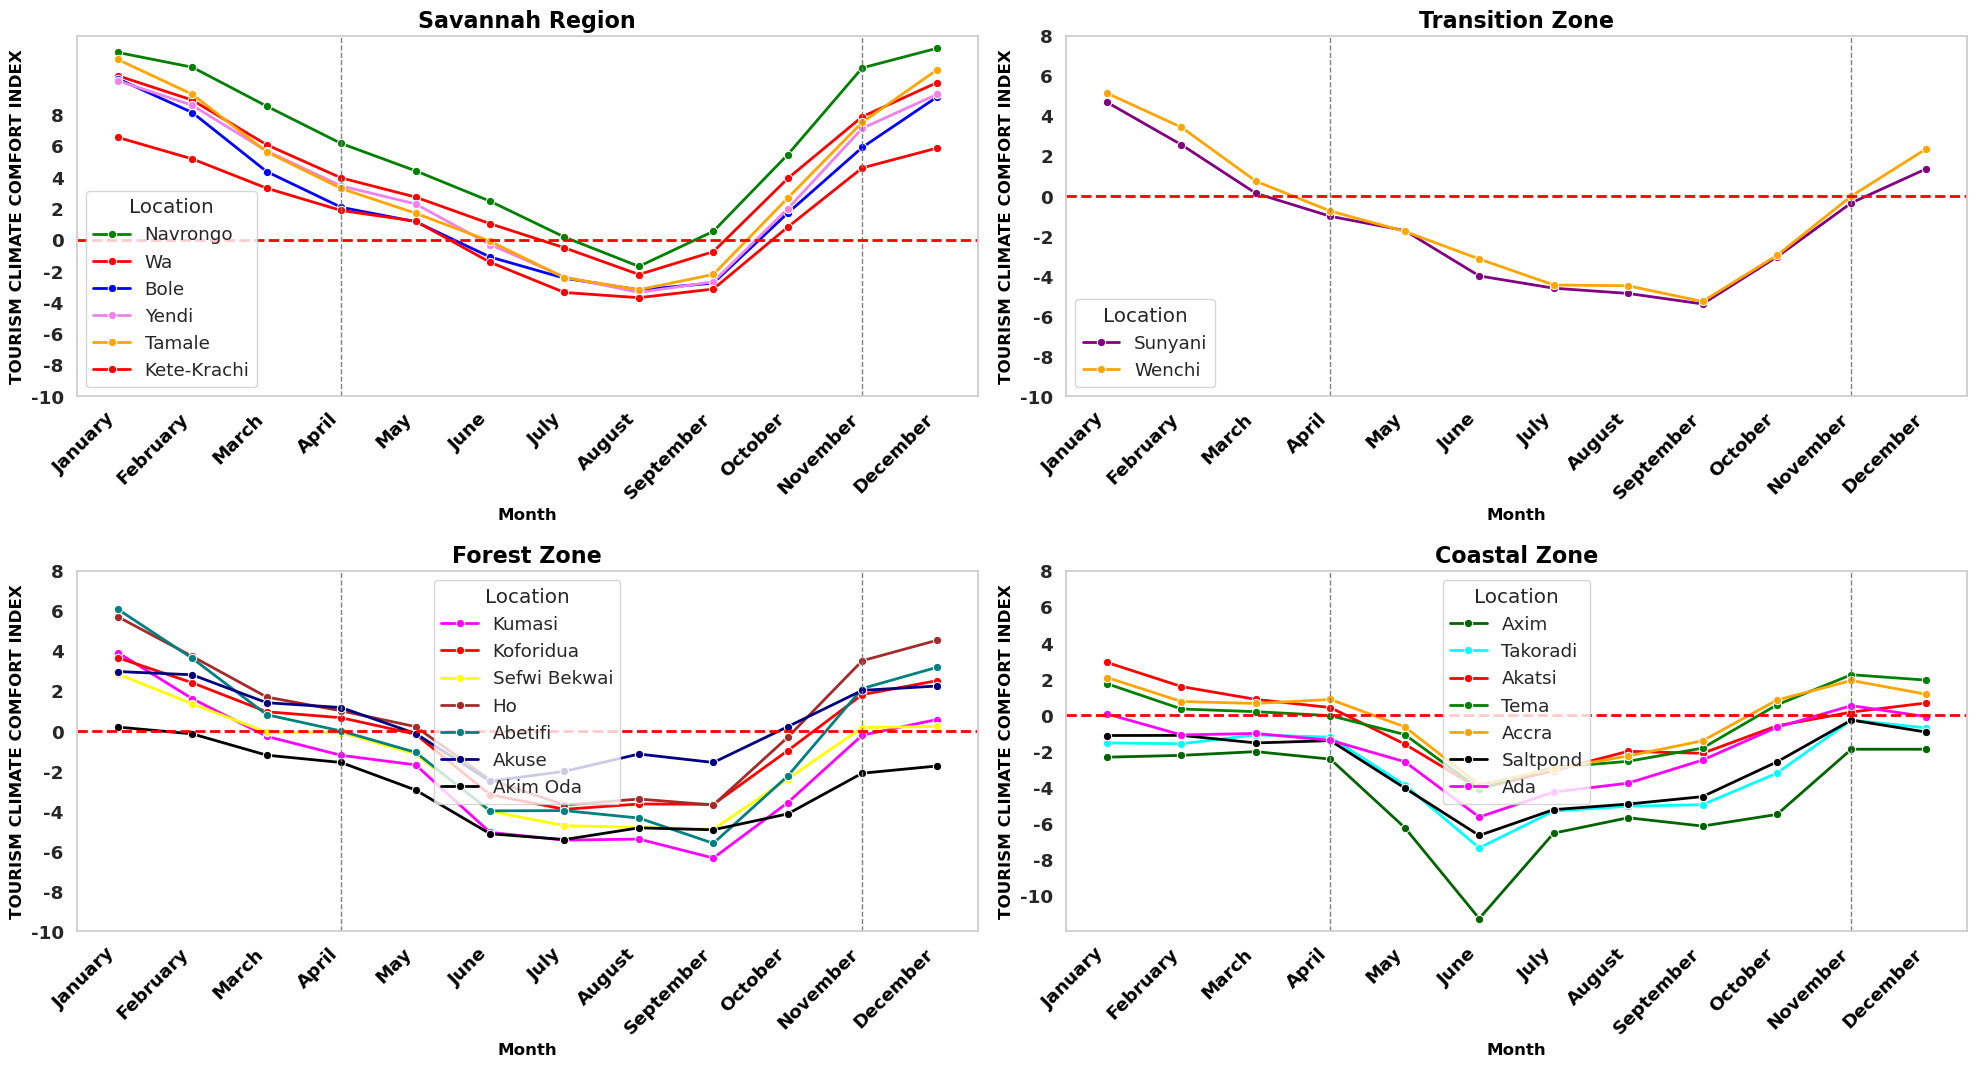

In [97]:
custom_colors = {
    'Navrongo': 'green',
    'Wa': 'red',
    'Bole': 'blue',
    'Yendi': 'violet',
    'Tamale': 'orange',
    'Kete-Krachi': 'red',
    'Sunyani': 'purple',
    'Wenchi': 'orange',
    'Kumasi': 'magenta',
    'Koforidua': 'red',
    'Sefwi Bekwai': 'yellow',
    'Ho': 'brown',
    'Abetifi': 'teal',
    'Akuse': 'navy',
    'Axim': 'darkgreen',
    'Takoradi': 'cyan',
    'Akim Oda': 'black',
    'Akatsi': 'red',
    'Tema': 'green',
    'Accra': 'orange',
    'Saltpond': 'black',
    'Ada': 'magenta'
}

zone_order = [
    'Savannah Region', 
    'Transition Zone', 
    'Forest Zone', 
    'Coastal Zone'
]

location_groups = {
    'Savannah Region': ['Navrongo','Wa','Bole', 'Yendi', 'Tamale','Kete-Krachi'],
    'Transition Zone': ['Sunyani', 'Wenchi'],
    'Forest Zone': ['Kumasi', 'Koforidua', 'Sefwi Bekwai', 'Ho', 'Abetifi', 'Akuse', 'Akim Oda'],
    'Coastal Zone': ['Axim', 'Takoradi','Akatsi', 'Tema', 'Accra', 'Saltpond', 'Ada']
}


fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=False)
axes = axes.flatten()

for idx, zone in enumerate(zone_order):
    ax = axes[idx]
    zone_locations = location_groups[zone]
    
    for location in zone_locations:
        location_data = tcci_data[tcci_data['Location'] == location]
        
        sns.lineplot(data=location_data, x='Month', y='TCCI', 
                     hue='Location', marker='o', linewidth=2, 
                     palette={location: custom_colors[location]}, ax=ax)

    ax.axvline(x=4, color='gray', linestyle='--', linewidth=1) 
    ax.axvline(x=11, color='gray', linestyle='--', linewidth=1) 
    
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)  

    ax.set_title(f'{zone}', fontsize=16, fontweight='bold', color='black')
    ax.set_xlabel('Month', fontsize=12, fontweight='bold', color='black')
    ax.set_ylabel('TOURISM CLIMATE COMFORT INDEX', fontsize=12, fontweight='bold', color='black')

    month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    ax.set_xticks(range(1, 13))
    ax.set_yticks(range(-10, 10, 2))
    ax.set_xticklabels(month_labels, rotation=45, ha='right', color='black', fontweight='bold')
    ax.set_yticklabels([str(int(tick)) for tick in ax.get_yticks()], fontweight='bold')
    ax.grid(False)

if len(zone_order) < len(axes):
    for j in range(len(zone_order), len(axes)):
        fig.delaxes(axes[j])


plt.tight_layout()
plt.savefig('TCCI_AGCZ_TIMESERIES.png')

plt.show()


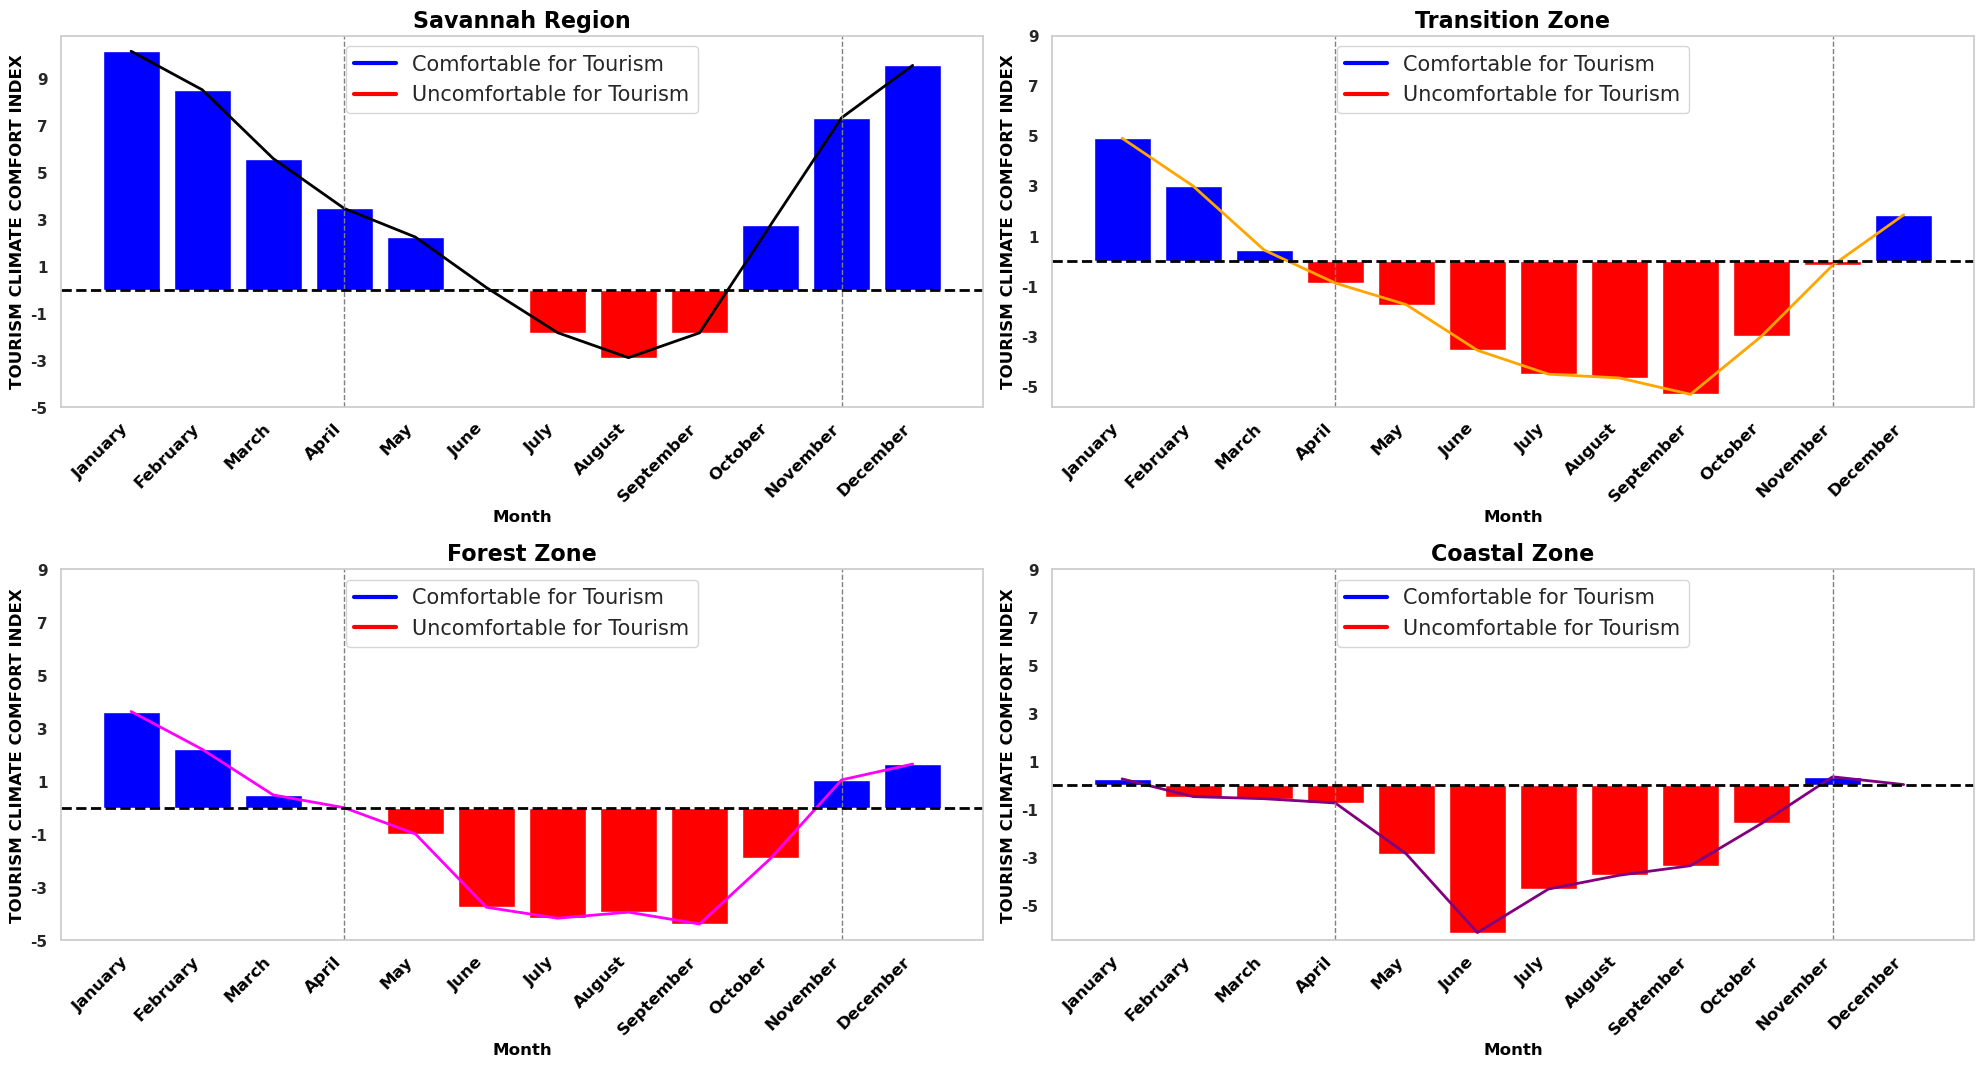

In [98]:

zone_colors = {'Savannah Region':'black', 'Transition Zone': 'orange', 'Forest Zone': 'magenta', 'Coastal Zone': 'purple'}
mean_tcci_per_location = tcci_data.groupby(['Location', 'Month'])['TCCI'].mean().reset_index()

zone_means = {}
for zone, locations in location_groups.items():
    zone_data = mean_tcci_per_location[mean_tcci_per_location['Location'].isin(locations)]
    zone_mean = zone_data.groupby('Month')['TCCI'].mean().reset_index() 
    zone_means[zone] = zone_mean 

sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(20, 15), sharey=False)
axes = axes.flatten()

blue_patch = mlines.Line2D([0], [0], color='blue', lw=3, label='Comfortable for Tourism')
red_patch = mlines.Line2D([0], [0], color='red', lw=3, label='Uncomfortable for Tourism')

for idx, zone in enumerate(zone_order):
    ax = axes[idx]
    
    zone_mean = zone_means[zone]
    
    for i, month in enumerate(zone_mean['Month']):
        if zone_mean.loc[i, 'TCCI'] > 0:
            color = 'blue' 
        else:
            color = 'red'  
        ax.bar(month, zone_mean.loc[i, 'TCCI'], color=color, width=0.8)
    
    sns.lineplot(x=zone_mean['Month'], y=zone_mean['TCCI'], color=zone_colors[zone], ax=ax, linewidth=2)
    
    ax.axvline(x=4, color='gray', linestyle='--', linewidth=1)  
    ax.axvline(x=11, color='gray', linestyle='--', linewidth=1)  
    ax.axhline(y=0, color='black', linestyle='--', linewidth=2)  
    ax.set_title(f'{zone}', fontsize=16, fontweight='bold', color='black')
    ax.set_xlabel('Month', fontsize=12, fontweight='bold', color='black')
    ax.set_ylabel('TOURISM CLIMATE COMFORT INDEX', fontsize=12, fontweight='bold', color='black')

    month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    ax.set_xticks(range(1, 13))
    ax.set_yticks(range(-5, 10, 2))
    ax.set_xticklabels(month_labels, rotation=45, ha='right', fontsize=12, color='black', fontweight='bold')

    ax.set_yticklabels([str(int(tick)) for tick in ax.get_yticks()], fontweight='bold')
    ax.grid(False)

    ax.legend(handles=[blue_patch, red_patch], loc='upper center', fontsize=15)


if len(zone_order) < len(axes):
    for j in range(len(zone_order), len(axes)):
        fig.delaxes(axes[j])

plt.subplots_adjust(hspace=0.1, wspace=0.5)
plt.tight_layout()

plt.savefig('TCCI_ZONES_MEAN_BARPLOT.png',dpi=300)

In [99]:
tcci_data.max()

Location        Yendi
Month              12
TCCI        12.239121
dtype: object

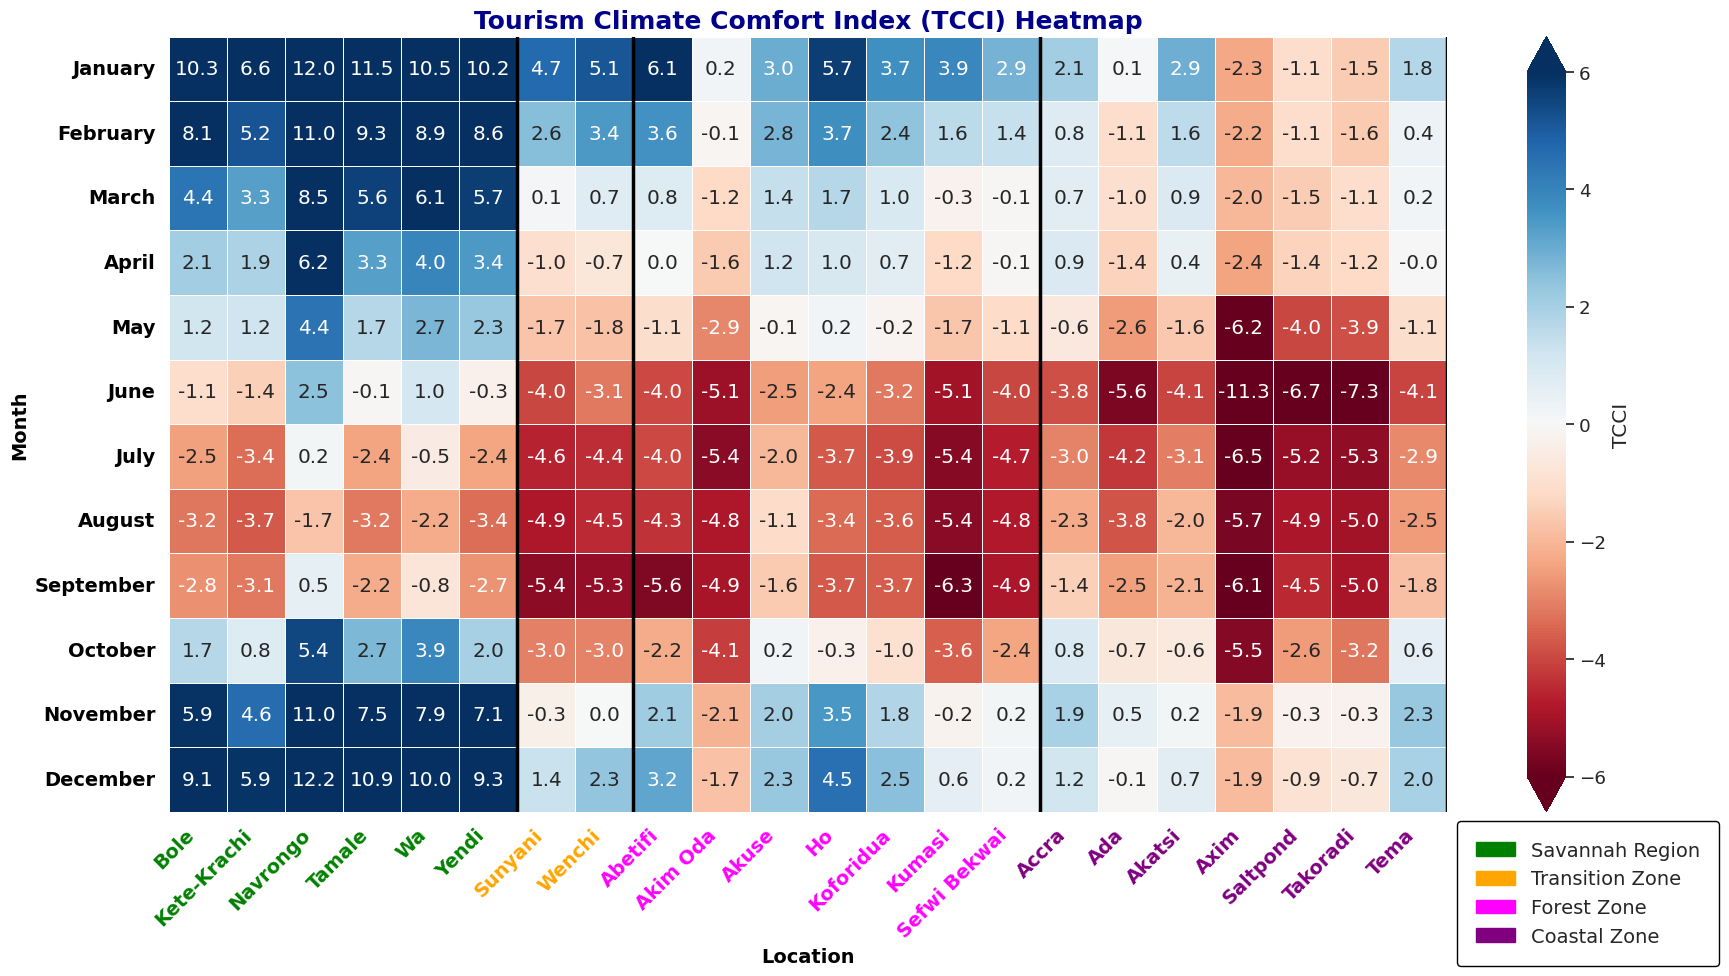

In [100]:
tcci_data['Zone'] = tcci_data['Location'].apply(lambda x: 
                                                 'Savannah Region' if x in location_groups['Savannah Region'] else 
                                                 'Transition Zone' if x in location_groups['Transition Zone'] else 
                                                 'Forest Zone' if x in location_groups['Forest Zone'] else 
                                                 'Coastal Zone')

pivoted_data = tcci_data.pivot_table(index='Month', columns='Location', values='TCCI', aggfunc='mean')
zone_order = ['Savannah Region', 'Transition Zone', 'Forest Zone', 'Coastal Zone']
location_zone_order = {loc: tcci_data.loc[tcci_data['Location'] == loc, 'Zone'].values[0] for loc in pivoted_data.columns}

sorted_locations = sorted(pivoted_data.columns, key=lambda x: zone_order.index(location_zone_order[x]))

pivoted_data = pivoted_data[sorted_locations]

zone_colors = {
    'Savannah Region':'green',  
    'Transition Zone': 'orange', 
    'Forest Zone': 'magenta', 
    'Coastal Zone': 'purple'
}
location_colors = [zone_colors[tcci_data.loc[tcci_data['Location'] == location, 'Zone'].values[0]] for location in pivoted_data.columns]

plt.figure(figsize=(18, 10))
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

heatmap = sns.heatmap(
    pivoted_data,
    cmap='RdBu',               
    annot=True,               
    fmt='.1f',                
    linewidths=0.5,            
    cbar_kws={'label': 'TCCI', 'extend': 'both'}, 
    xticklabels=True,      
    yticklabels=month_labels,        
    cbar=True,             
    linecolor='white',       
    vmax=6, vmin=-6,          
)

plt.title('Tourism Climate Comfort Index (TCCI) Heatmap', fontsize=18, weight='bold', color='darkblue')
plt.xlabel('Location', fontsize=14, weight='bold', color='black')
plt.ylabel('Month', fontsize=14, weight='bold', color='black')

for i, label in enumerate(plt.gca().get_xticklabels()):
    label.set_color(location_colors[i])

plt.xticks(rotation=45, ha='right', fontsize=14, weight='bold')
plt.yticks(rotation=0, fontsize=14, weight='bold',color='black')

zone_start_index = 0
for i, zone in enumerate(zone_order):
    zone_end_index = sum([1 for loc in sorted_locations if location_zone_order[loc] == zone]) + zone_start_index
    plt.axvline(x=zone_end_index - 0, color='black', linewidth=2.5)  
    zone_start_index = zone_end_index

handles = [mpatches.Patch(color=color, label=zone) for zone, color in zone_colors.items()]
plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1, 0), fontsize=14, 
           frameon=True, facecolor='white', edgecolor='black', framealpha=1, borderpad=1)

plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, color='grey', alpha=0.7)

plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['right'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_linewidth(0.2)
plt.gca().spines['left'].set_color('black')

plt.gcf().set_facecolor('white')

colorbar = plt.gca().collections[0].colorbar
colorbar.set_ticks([-6, -4, -2, 0, 2, 4, 6])

plt.tight_layout()
plt.savefig('HEATMAP_TCCI_with_zones.png', dpi=800)

plt.show()


In [101]:
color

'blue'

In [102]:
a=['G','TRansition','d','k']
for x in a:
    print(x)

G
TRansition
d
k


In [103]:

region_coords = {
    'Navrongo': (10.89557, -1.0921),
    'Wa': (10.06069, -2.50192),
    'Bole': (9.0333332, -2.4833314),
    'Yendi': (9.44272, -0.00991),
    'Tamale': (9.40079, -0.8393),
    'Kete-Krachi': (7.7999968, -0.0166666),
    'Sunyani': (7.33991, -2.32676),
    'Wenchi': (7.73916, -2.10456),
    'Kumasi': (6.68848, -1.62443),
    'Koforidua': (6.083333, -0.249999),
    'Sefwi Bekwai': (6.1980, -2.3246),
    'Ho': (6.60084, -0.4713),
    'Abetifi': (6.6713, -0.7462),
    'Akuse': (6.1018, 0.1277),
    'Axim': (4.86992, -2.24046),
    'Takoradi': (4.88447, -1.75536),
    'Akim Oda': (5.92665, -0.98577),
    'Akatsi': (6.12475116766, 0.792559663082),
    'Tema': (5.6387, -0.0015),
    'Accra': (5.614818, -0.205874),
    'Saltpond': (5.20913, -1.06058),
    'Ada': (5.7666636, 0.6166642)
}

In [104]:
# Adding Latitude and Longitude to TCCI data
tcci_data['Longitude'] = tcci_data['Location'].map(lambda x: region_coords[x][1] if x in region_coords else np.nan)
tcci_data['Latitude'] = tcci_data['Location'].map(lambda x: region_coords[x][0] if x in region_coords else np.nan)

# Drop rows with missing coordinates or TCCI
tcci_data = tcci_data.dropna(subset=['Longitude', 'Latitude', 'TCCI'])


In [106]:
# checking if all data and stations are present

In [107]:

unique_stations = tcci_data['Location'].unique()
print("Stations in data:")
for station in unique_stations:
    print(station)

station_counts = tcci_data['Location'].value_counts()
print("\nData points per station:")
print(station_counts)


Stations in data:
Abetifi
Accra
Ada
Akatsi
Akim Oda
Akuse
Axim
Bole
Ho
Kete-Krachi
Koforidua
Kumasi
Navrongo
Saltpond
Sefwi Bekwai
Sunyani
Takoradi
Tamale
Tema
Wa
Wenchi
Yendi

Data points per station:
Location
Abetifi         12
Accra           12
Wenchi          12
Wa              12
Tema            12
Tamale          12
Takoradi        12
Sunyani         12
Sefwi Bekwai    12
Saltpond        12
Navrongo        12
Kumasi          12
Koforidua       12
Kete-Krachi     12
Ho              12
Bole            12
Axim            12
Akuse           12
Akim Oda        12
Akatsi          12
Ada             12
Yendi           12
Name: count, dtype: int64


/tmp/ipykernel_29822/1020913457.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  ghana_polygon = ghana.geometry.unary_union


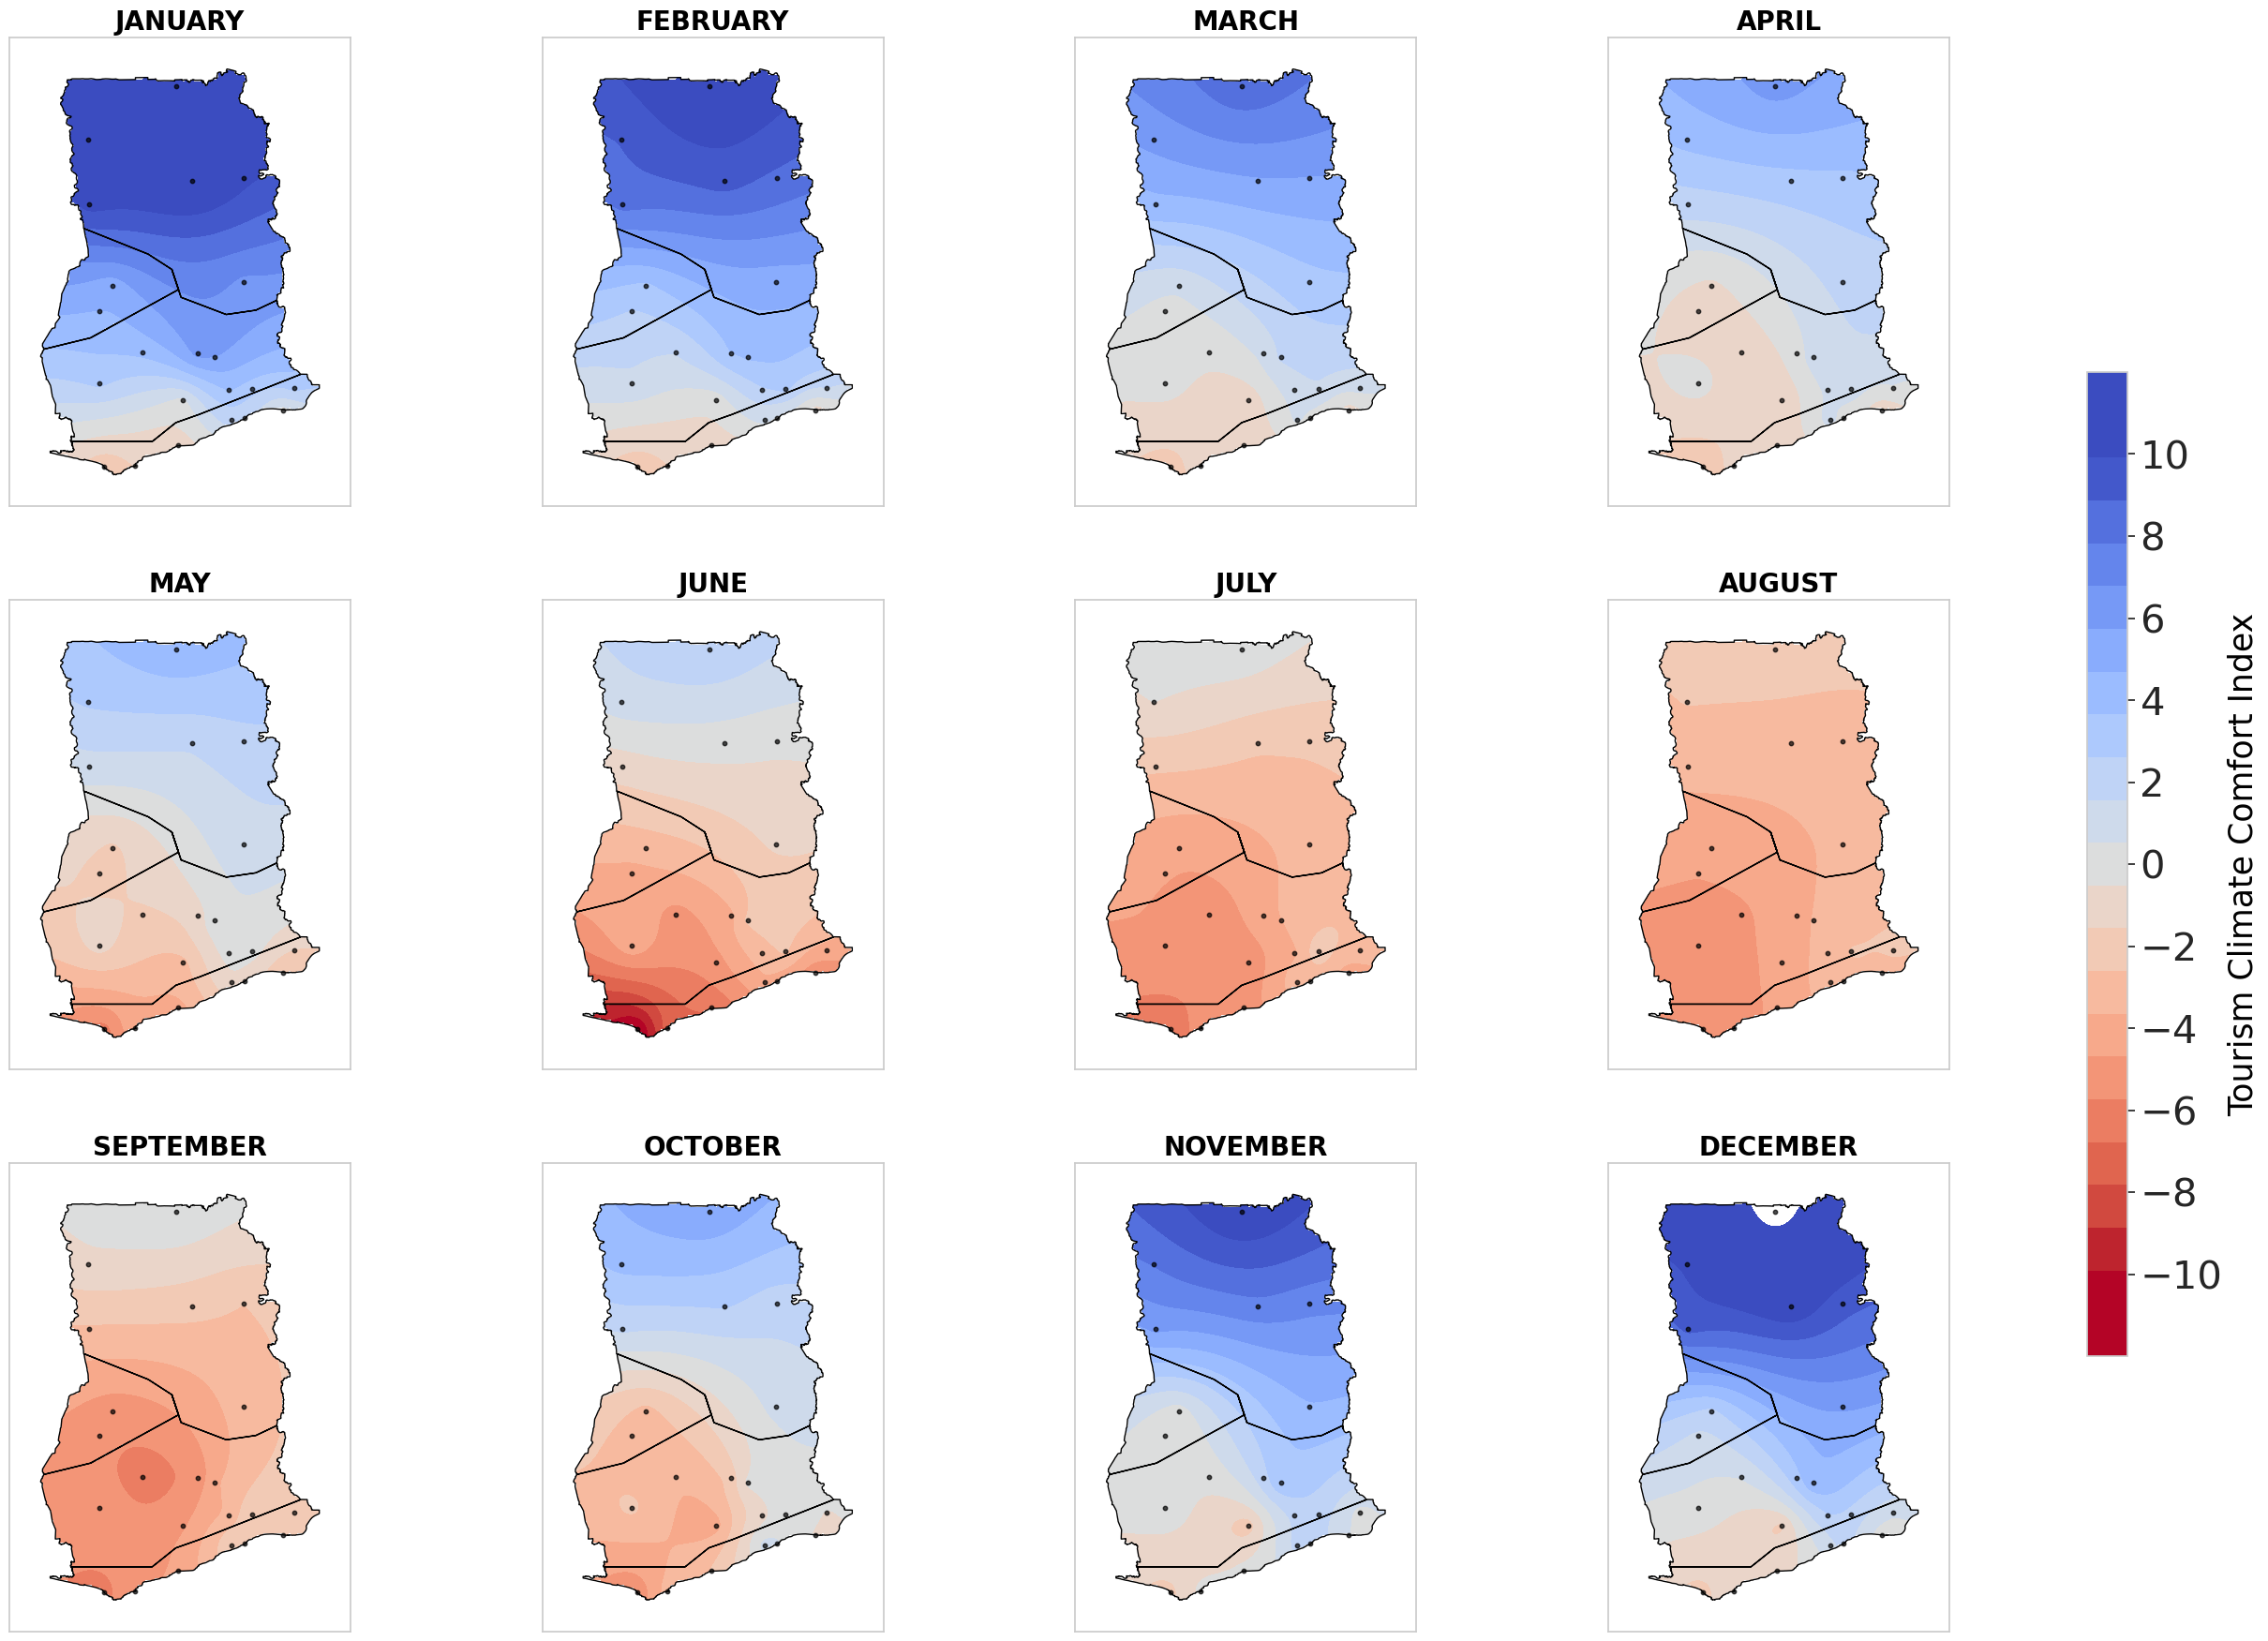

In [109]:
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point

month_names = ["JANUARY", "FEBRUARY", "MARCH", "APRIL", "MAY", "JUNE",
               "JULY", "AUGUST", "SEPTEMBER", "OCTOBER", "NOVEMBER", "DECEMBER"]

ghana = gpd.read_file('/home/pinkrah-nana-ofosuhene/Downloads/New_ACZ_Map/TCCI_shapefile/TCCI_shapefile.shp')
ghana_polygon = ghana.geometry.unary_union

# Creating interpolation grid
min_lon, min_lat, max_lon, max_lat = ghana.total_bounds
buffer = 0.5
grid_lon = np.linspace(min_lon - buffer, max_lon + buffer, 200)
grid_lat = np.linspace(min_lat - buffer, max_lat + buffer, 200)
grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)

fig, axes = plt.subplots(3, 4, figsize=(29, 21))
#fig.suptitle('TCCI Interpolation Using Ordinary Kriging', fontsize=20, weight='bold')

for i in range(12):
    month = i + 1
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Filter data for the month
    month_data = tcci_data[tcci_data['Month'] == month].dropna(subset=['Longitude', 'Latitude', 'TCCI'])
    if month_data.empty:
        ax.set_title(month_names[i] + " (No Data)")
        ax.axis('off')
        continue

    lons = month_data['Longitude'].values
    lats = month_data['Latitude'].values
    tcci_vals = month_data['TCCI'].values

    # Performing the Kriging
    try:
        OK = OrdinaryKriging(
            lons, lats, tcci_vals,
            variogram_model='linear',  # Try 'spherical', 'gaussian' too
            verbose=False,
            enable_plotting=False
        )
        z, ss = OK.execute('grid', grid_lon, grid_lat)

        # Mask values outside Ghana
        mask = np.array([ghana_polygon.contains(Point(x, y)) for x, y in zip(grid_x.flatten(), grid_y.flatten())])
        z_flat = z.flatten()
        z_flat[~mask] = np.nan
        z_masked = z_flat.reshape(grid_x.shape)

        # Ploting interpolated surface
        contour = ax.contourf(
            grid_x, grid_y, z_masked,
            cmap='coolwarm_r',
            levels=np.linspace(-12, 12, 24),
            vmin=-10, vmax=10
        )

        ghana.boundary.plot(ax=ax, color='black', linewidth=1)
        ax.scatter(lons, lats, c='black', s=10, alpha=0.7, label='TCCI Points')
        ax.set_title(month_names[i], fontsize=20,color='black', weight='bold')
        ax.set_xlim(min_lon - buffer, max_lon + buffer)
        ax.set_ylim(min_lat - buffer, max_lat + buffer)
        ax.set_xticks([])
        ax.set_yticks([])
    except Exception as e:
        ax.set_title(month_names[i] + " (Error)")
        ax.axis('off')
        print(f"Failed to interpolate {month_names[i]}: {e}")

plt.subplots_adjust(hspace=0.2, wspace=0.05, top=0.92)
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Tourism Climate Comfort Index', fontsize=25, color='black')
cbar.set_ticks(np.arange(-10, 11, 2))
cbar.ax.tick_params(labelsize=30)

plt.savefig('TCCI_Kriging_All_Months.png', dpi=500, bbox_inches='tight')
plt.show()


In [110]:
print(tcci_data[tcci_data['Location'] == 'Accra'])


   Location  Month      TCCI          Zone  Longitude  Latitude
12    Accra      1  2.095479  Coastal Zone  -0.205874  5.614818
13    Accra      2  0.764951  Coastal Zone  -0.205874  5.614818
14    Accra      3  0.658789  Coastal Zone  -0.205874  5.614818
15    Accra      4  0.879618  Coastal Zone  -0.205874  5.614818
16    Accra      5 -0.639154  Coastal Zone  -0.205874  5.614818
17    Accra      6 -3.849515  Coastal Zone  -0.205874  5.614818
18    Accra      7 -2.965088  Coastal Zone  -0.205874  5.614818
19    Accra      8 -2.251686  Coastal Zone  -0.205874  5.614818
20    Accra      9 -1.410820  Coastal Zone  -0.205874  5.614818
21    Accra     10  0.845484  Coastal Zone  -0.205874  5.614818
22    Accra     11  1.932169  Coastal Zone  -0.205874  5.614818
23    Accra     12  1.170584  Coastal Zone  -0.205874  5.614818


In [108]:
# List all unique station names
unique_stations = tcci_data['Location'].unique()
print("Stations in data:")
for station in unique_stations:
    print(station)

# Optional: Show how many data points per station
station_counts = tcci_data['Location'].value_counts()
print("\nData points per station:")
print(station_counts)


Stations in data:
Abetifi
Accra
Ada
Akatsi
Akim Oda
Akuse
Axim
Bole
Ho
Kete-Krachi
Koforidua
Kumasi
Navrongo
Saltpond
Sefwi Bekwai
Sunyani
Takoradi
Tamale
Tema
Wa
Wenchi
Yendi

Data points per station:
Location
Abetifi         12
Accra           12
Wenchi          12
Wa              12
Tema            12
Tamale          12
Takoradi        12
Sunyani         12
Sefwi Bekwai    12
Saltpond        12
Navrongo        12
Kumasi          12
Koforidua       12
Kete-Krachi     12
Ho              12
Bole            12
Axim            12
Akuse           12
Akim Oda        12
Akatsi          12
Ada             12
Yendi           12
Name: count, dtype: int64
